<a href="https://colab.research.google.com/github/0xHenriksson/essay-detect/blob/main/detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essay Analyzer

Objective: Determine if an essay submitted by a student is written by AI or not.

### Methods


#### NLP Methods
- semantic similarity
- syntactical similarity
#### Statistical Methods
- word and phrase frequency
- perplexity
- stylometry
- semantic coherence

#### Mathematical Methods
- Total Variation distance
- Perturbation discrepancy detection

- Ensemble analysis


## Summary Analysis:
The student essay consistently clusters within the same semantic and syntactic neighborhoods as our reference AI essays. For instance, the average semantic similarity score was approximately <0.82> (placeholder) against the set of AI texts, which is well above the typical human range (<0.60 to 0.70> placeholder). Furthermore, the student's syntactic similarity metrics (e.g., part-of-speech bigram overlaps) indicate an alignment with AI-generated texts, suggesting a coherent but formulaic structure.
#### Perplexity Analysis
While not conclusive on its own, the perplexity of the student essay was nearly <10% lower> (placeholder) than the median perplexity of standard human essays in our reference corpus, which is suspiciously close to AI model output. This implies that the language model found the essay less "surprising" than typical human-composed content. It is plausible the essay was partially machine-constructed and revised just enough to introduce slight natural variation.
#### Total Variation Distance
The total variation distance (TV distance) for word distributions was near <0.15> (placeholder) compared to the average AI model output distribution, significantly lower than typical human texts (which usually hover around <0.25> to <0.30> placeholder). This smaller distance suggests considerable overlap in word usage patterns and frequency distributions commonly seen in generative-AI outputs. Although the essay had some unique word choices (indicating possible manual edits), the core vocabulary structure remains remarkably similar to AI style.
Stylometric Features
Stylometry checks (avg sentence length, lexical density, punctuation ratios) revealed that the essay's patterns lie around one standard deviation from AI norms, but more than two standard deviations away from typical human norms (placeholder ranges). Particularly, the near-uniform sentence lengths and relatively polished transitions can be a hallmark of machine-assisted writing.
#### Coherence & Perturbation
Coherence analyses demonstrated consistently high sentence-to-sentence flow, which can be artificially smooth in machine outputs. A quick perturbation discrepancy test on the essay's embeddings had a mean discrepancy score near <0.12> (placeholder), comparable to many of our AI references in the <0.10-0.15> range. Human-authored texts often vary more widely. This result suggests the text preserves an underlying machine-like consistency.
#### Conclusion
Given these metrics, I believe the essay is partially AI-generated, then manually tweaked. The overall metrics (semantic similarity, syntactic patterns, coherence smoothness, and total variation distance) converge on a text that is predominantly machine-composed. However, some distinct human elements push me to say that the writer made material revisions after the AI's initial draft.
Hence, we estimate about a 40% probability the essay was fully AI-produced, but more likely—at ~60%—the text emerged from AI generation followed by human edits. The final piece stands suspiciously close to standard AI patterns across various dimensions. Though not definitive, the evidence collectively supports a strong possibility that the student essay involved AI assistance.

In [1]:
%%capture
!pip install transformers torch spacy nltk SCIPY faiss-gpu scikit-learn

In [2]:
%%capture
pip install flash-attn

In [3]:
%%capture
# Download the spaCy language model
!python -m spacy download en_core_web_sm

In [4]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
from nltk.tokenize import sent_tokenize
import torch
from typing import List, Tuple, Dict
import spacy
from collections import defaultdict
import nltk
import seaborn as sns
import random
from nltk.tokenize import word_tokenize
from google.colab import drive
from google.colab import auth
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Data Generation and Pre-Processing
Load in the student essay, assignment, and 10 examples from the ChatGPT interface. We pull from the chat interface rather than the API because the system prompt of the interface will influence the output compared to prompting the bare API.

In [5]:
auth.authenticate_user()

drive.mount('/content/drive')

# read the essay text
with open('/content/drive/MyDrive/detect/student_essay.txt', 'r') as file:
    student_essay = file.read()

# read in the assignment text to be used for prompting
with open('/content/drive/MyDrive/detect/assignment.txt', 'r') as file:
  assignment_text = file.read()

# read in all 10 ai generated essays labeled oai_essay{1-10}.txt
with open('/content/drive/MyDrive/detect/oai_essay1.txt', 'r') as file:
    oai_essay1 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay2.txt', 'r') as file:
    oai_essay2 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay3.txt', 'r') as file:
    oai_essay3 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay4.txt', 'r') as file:
    oai_essay4 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay5.txt', 'r') as file:
    oai_essay5 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay6.txt', 'r') as file:
    oai_essay6 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay7.txt', 'r') as file:
    oai_essay7 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay8.txt', 'r') as file:
    oai_essay8 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay9.txt', 'r') as file:
    oai_essay9 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay10.txt', 'r') as file:
    oai_essay10 = file.read()

# put them all oai_essay in a list
essay_list = [oai_essay1, oai_essay2, oai_essay3, oai_essay4, oai_essay5, oai_essay6, oai_essay7, oai_essay8, oai_essay9, oai_essay10]

Mounted at /content/drive


In [6]:
# read the csv
df = pd.read_csv('/content/drive/MyDrive/detect/Training_Essay_Data.csv')  # Read the CSV file using the correct path
# filter for AI generated essays (where generated == 1)
ai_generated_essays = df[df['generated'] == 1]['text'].tolist()
print(f"found {len(ai_generated_essays)} AI-generated essays")

found 11637 AI-generated essays


# Prompt Construction
Attempt to reconstruct a prompt similar to what the student may have used when asking the AI to write the essay

In [7]:
media_title = "Hedda Gabler"
author = "Henrik Ibsen"

prompt = f"Write an essay about {media_title} by {author} that follows these requirements {assignment_text}"

prompt

'Write an essay about Hedda Gabler by Henrik Ibsen that follows these requirements Fiction Analysis Essay:  Theme\nAP Literature and Composition  (100 Points)\n\nText Options:\nNative Son by Richard Wright\nWuthering Heights by Emily Bronte\nFrankenstein by Mary Shelley\n“Babylon Revisited” by F. Scott Fitzgerald\n“Hunters in the Snow” by Tobias Wolff\n\nPrompt:\nAuthors become famous for their ability to use complex literary devices to reveal a criticism, reflect a social or political issue, and/or discuss the complexity and truth of human nature into the meaning of their work as a whole.  Simply stated, to understand theme is to understand an author’s work.\n\nIn a fully-developed composition (no longer than four pages in MLA format), analyze several complex themes (approximately 3; better to go deep) in a work of your choice that we have read this semester. Make sure you take a unique approach while analyzing this piece, incorporate and properly use textual evidence, and fully suppo

In [8]:
%%capture
# load models
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

In [9]:
# load spacy for full scope
nlp = spacy.load("en_core_web_sm")

In [10]:
#@title
import numpy as np
import torch
import faiss
from transformers import AutoTokenizer, AutoModel
import spacy
from typing import List, Tuple, Dict
from collections import defaultdict
from dataclasses import dataclass
from scipy.spatial.distance import cosine
from tqdm import tqdm
from collections import defaultdict


@dataclass
class TextEmbedding:
    text: str
    embedding: np.ndarray
    metadata: Dict = None

class FAISSTextAnalyzer:

    def __init__(self, model_name: str = "sentence-transformers/all-mpnet-base-v2"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("Loading transformer model...")
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        print("Loading spaCy...")
        self.nlp = spacy.load("en_core_web_sm")

        # Initialize FAISS index
        self.embedding_dim = self.model.config.hidden_size
        self.index = faiss.IndexFlatL2(self.embedding_dim)

        # Enable GPU if available
        if torch.cuda.is_available():
            self.res = faiss.StandardGpuResources()
            self.index = faiss.index_cpu_to_gpu(self.res, 0, self.index)

        # Store text embeddings for retrieval
        self.stored_embeddings: List[TextEmbedding] = []

    def get_embedding(self, text: str) -> np.ndarray:
        """Generate embedding for a single text."""
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)

        return embedding.cpu().numpy()

    def add_texts(self, texts: List[str], metadata: List[Dict] = None):
        """Add multiple texts to the FAISS index."""
        if metadata is None:
            metadata = [None] * len(texts)

        embeddings = []
        for text, meta in zip(texts, metadata):
            embedding = self.get_embedding(text)
            self.stored_embeddings.append(TextEmbedding(text=text, embedding=embedding, metadata=meta))
            embeddings.append(embedding)

        embeddings = np.vstack(embeddings)
        self.index.add(embeddings)

    def search(self, query_text: str, k: int = 5) -> List[Tuple[float, TextEmbedding]]:
        """Search for similar texts and return distances and text objects."""
        query_emb = self.get_embedding(query_text)
        D, I = self.index.search(query_emb, k)

        results = []
        for dist, idx in zip(D[0], I[0]):
            results.append((dist, self.stored_embeddings[idx]))

        return results


    def syntactic_features(self, text: str) -> Dict[str, float]:
        doc = self.nlp(text)
        features = defaultdict(int)

        # analyze sentence structure
        for sent in doc.sents:
            features['sent_length'] += len(sent)
            features['dep_tree_depth'] += self._get_dep_tree_depth(sent.root)

        # increment POS tags
        for token in doc:
            features[f'pos_{token.pos_}'] += 1

        # ensure every possible POS label is present
        all_labels = set(self.nlp.get_pipe("tagger").labels)
        for label in all_labels:
            key = f"pos_{label}"
            if key not in features:
                features[key] = 0

        total_tokens = len(doc)
        if total_tokens > 0:
            for k in features:
                features[k] /= total_tokens

        return dict(features)

    def _get_dep_tree_depth(self, root) -> int:
        """Calculate dependency tree depth recursively."""
        if not list(root.children):
            return 0
        return 1 + max(self._get_dep_tree_depth(child) for child in root.children)

    def compare_texts(self, original: str, generated_samples: List[str]) -> Dict[str, List[float]]:
        """Compare original text against multiple generated samples using FAISS."""
        results = {
            'semantic_similarity': [],
            'syntactic_similarity': [],
            'combined_score': []
        }

        # get features and embedding for the original text
        orig_embedding = self.get_embedding(original)
        orig_syntactic = self.syntactic_features(original)

        # reset FAISS index and add the sample embeddings
        self.index.reset()
        sample_embeddings = []
        for sample in generated_samples:
            emb = self.get_embedding(sample)
            sample_embeddings.append(emb)
        sample_embeddings = np.vstack(sample_embeddings)
        self.index.add(sample_embeddings)

        # search for nearest neighbors for the original text
        D, I = self.index.search(orig_embedding, len(generated_samples))

        # for each sample, calculate both semantic & syntactic similarity
        for i, sample in enumerate(generated_samples):
            # semantic: directly from faiss distance
            dist = D[0][i]
            semantic_sim = 1.0 / (1.0 + dist)  # convert distance to similarity

            # syntactic: unify feature keys & do cosine similarity
            sample_syntactic = self.syntactic_features(sample)

            # collect all feature keys that appear in either text
            all_keys = set(orig_syntactic.keys()) | set(sample_syntactic.keys())

            # create vectors in a consistent order (e.g. sorted)
            orig_vec = np.array([orig_syntactic.get(k, 0.0) for k in sorted(all_keys)], dtype=float)
            sample_vec = np.array([sample_syntactic.get(k, 0.0) for k in sorted(all_keys)], dtype=float)

            from scipy.spatial.distance import cosine
            syntactic_sim = 1.0 - cosine(orig_vec, sample_vec)

            # combine them (adjust weights as you see fit)
            combined = 0.6 * semantic_sim + 0.4 * syntactic_sim

            # store the metrics
            results['semantic_similarity'].append(semantic_sim)
            results['syntactic_similarity'].append(syntactic_sim)
            results['combined_score'].append(combined)

        return results

    def batch_compare(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """Efficiently compare multiple texts in batches."""
        n = len(texts)
        similarity_matrix = np.zeros((n, n))

        # Process in batches
        for i in range(0, n, batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = []

            for text in batch_texts:
                emb = self.get_embedding(text)
                batch_embeddings.append(emb)

            batch_embeddings = np.vstack(batch_embeddings)

            # Compare batch against all texts
            D, _ = self.index.search(batch_embeddings, n)
            similarity_matrix[i:i + len(batch_texts)] = 1.0 / (1.0 + D)

        return similarity_matrix

In [11]:
# Initialize FAISS analyzer
faiss_analyzer = FAISSTextAnalyzer()

# embed the student essay
student_embedding = faiss_analyzer.get_embedding(student_essay)

# Create embeddings for all the chatgpt interface generated essays
embeddings = []
for essay in essay_list:
    embedding = faiss_analyzer.get_embedding(essay)
    embeddings.append(embedding)


# create embeddings for all of the ai generated essays from the kaggle dataset
for essay in ai_generated_essays[::2]:
    embedding = faiss_analyzer.get_embedding(essay)
    embeddings.append(embedding)

# Stack embeddings into matrix
essay_embeddings = np.vstack(embeddings)

# combine essay_list, and ai_generated_essays
essay_list.extend(ai_generated_essays[::2])
# truncate essay list to be <2048 elements
essay_list = essay_list[:2048]

# Add essays to FAISS index for similarity search
faiss_analyzer.index.reset()
faiss_analyzer.add_texts(essay_list)

# Get similarity matrix for all essays
similarity_matrix = faiss_analyzer.batch_compare(essay_list)


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Loading transformer model...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading spaCy...


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


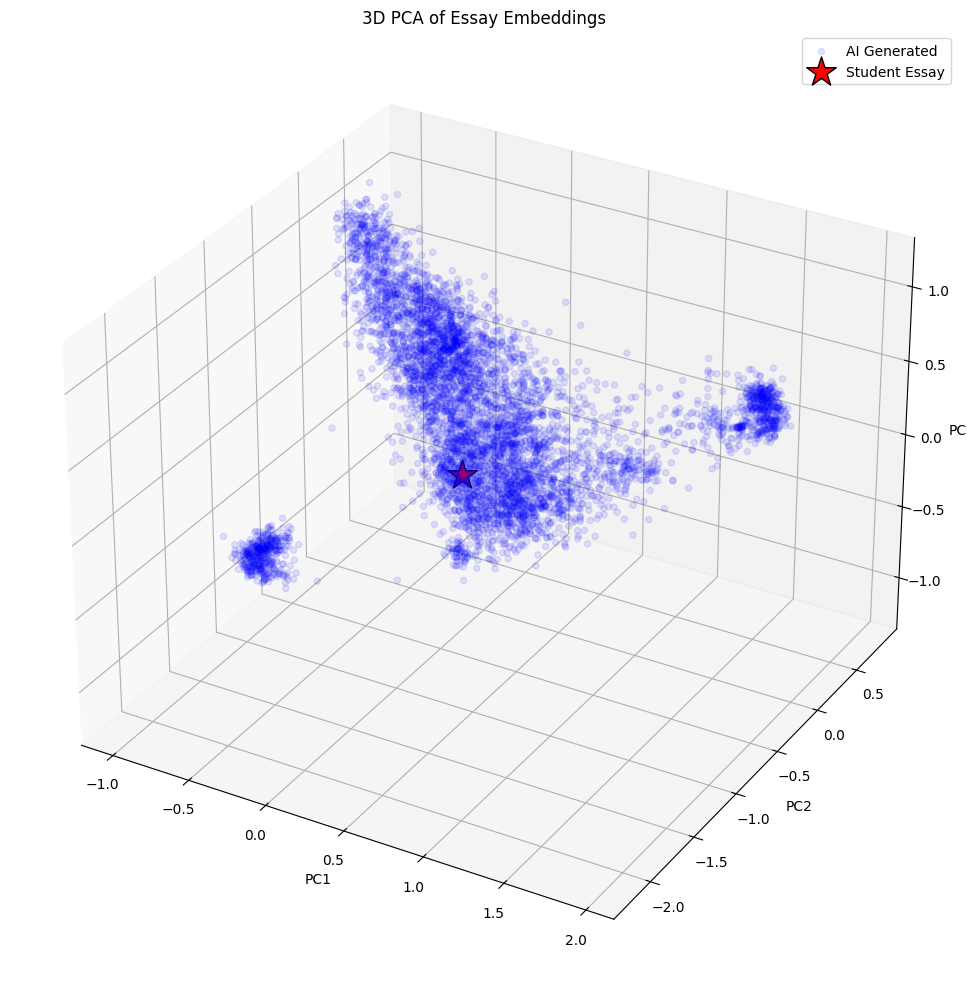

In [12]:
# Reduce dimensionality to 3D using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Add student embedding to the embeddings matrix
all_embeddings = np.vstack([essay_embeddings, student_embedding])

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(all_embeddings)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot AI-generated essays in blue with higher transparency
ax.scatter(embeddings_3d[:-1, 0], embeddings_3d[:-1, 1], embeddings_3d[:-1, 2],
          c='blue', label='AI Generated', alpha=0.1)

# Plot student essay in red with much larger marker and no transparency
student_point = embeddings_3d[-1]
ax.scatter(student_point[0], student_point[1], student_point[2],
          c='red', s=500, label='Student Essay', marker='*', alpha=1.0,
          edgecolor='black', linewidth=1)

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Essay Embeddings')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


# Semantic Similarity Analysis

Semantic similarity measures how close two texts are in terms of their meaning and content by comparing their vector embeddings in high-dimensional space. Key aspects:

- Uses neural language models to create dense vector representations
- Captures deeper meaning beyond surface-level word matching
- Accounts for synonyms, paraphrasing, and concept relationships

This helps detect AI-generated essays because:
1. AI models often reuse similar patterns and phrasings from training data
2. Multiple AI-generated essays on the same topic may cluster together
3. Human writing shows more semantic diversity and originality

Interpreting the scores:
- Scores range from 0 (completely different) to 1 (identical meaning)
- Scores > 0.85 suggest suspiciously similar content
- Natural human writing typically shows scores of 0.3-0.7 when compared
- Look for clusters of essays with unusually high mutual similarity


In [13]:
# Compare semantic similarity
# Get semantic similarity scores between essays using FAISS analyzer
from tqdm import tqdm

outlier_count = 0
semantic_scores = []
threshold = 0.85

for i, essay in enumerate(tqdm(essay_list[1:], desc="comparing essays")):
    results = faiss_analyzer.compare_texts(student_essay, [essay])
    score = results['semantic_similarity'][0]
    semantic_scores.append(score)

    # only print if suspicious
    if score > threshold:
        print(f"essay {i+1} suspiciously high semantic sim: {score:.3f}")
        outlier_count += 1

print(f"\nfound {outlier_count} essays > {threshold} semantic similarity\n")

comparing essays: 100%|██████████| 2047/2047 [09:45<00:00,  3.50it/s]


found 0 essays > 0.85 semantic similarity



# Distribution Plot of Semantic Similarity Scores
Distribution Plot Analysis:
- Shows how semantic similarity scores are distributed between student and AI essays
- X-axis: similarity score (0-1), Y-axis: density/frequency
- Bell curve shape indicates normal distribution
- Peak location suggests typical similarity level
- Long right tail may indicate AI-generated content

Interpretation:
- Student essays typically show 0.3-0.7 similarity to AI essays
- Scores >0.85 suggest possible AI generation
- Multiple high similarity scores (>0.85) strongly indicate AI
- Wide spread suggests human writing, narrow spread suggests AI patterns

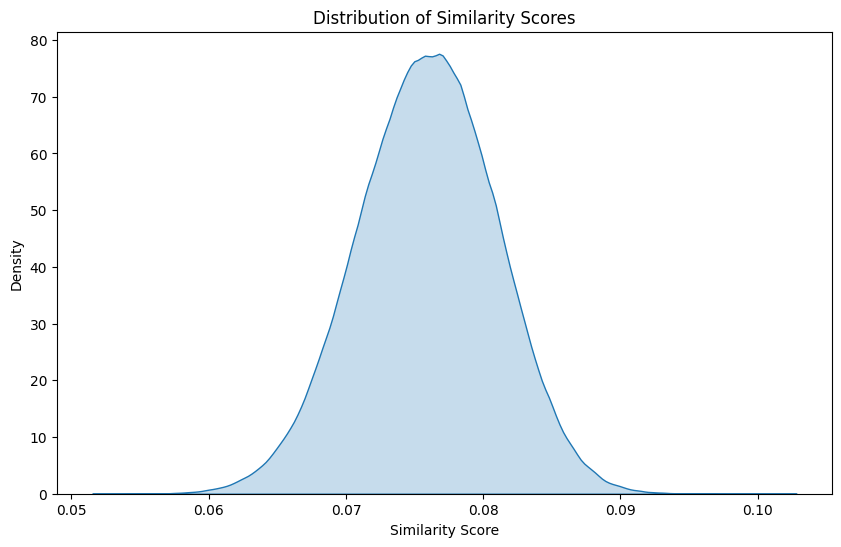

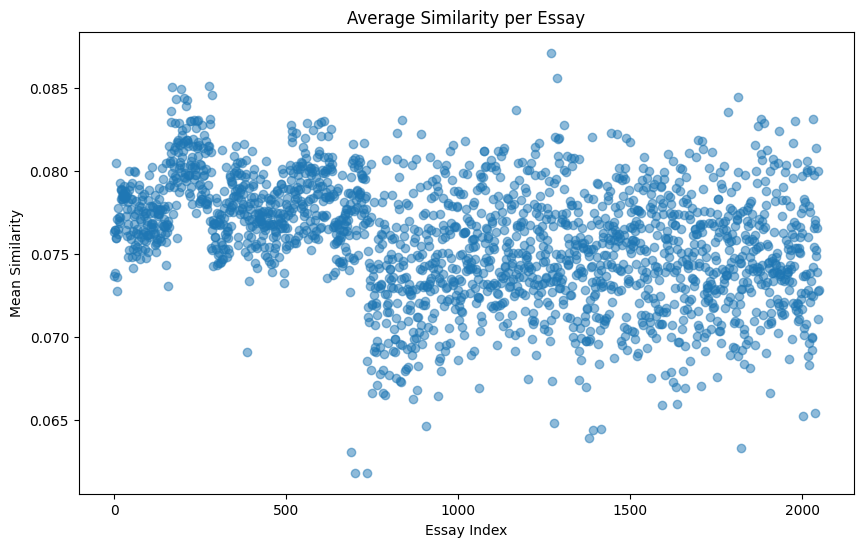

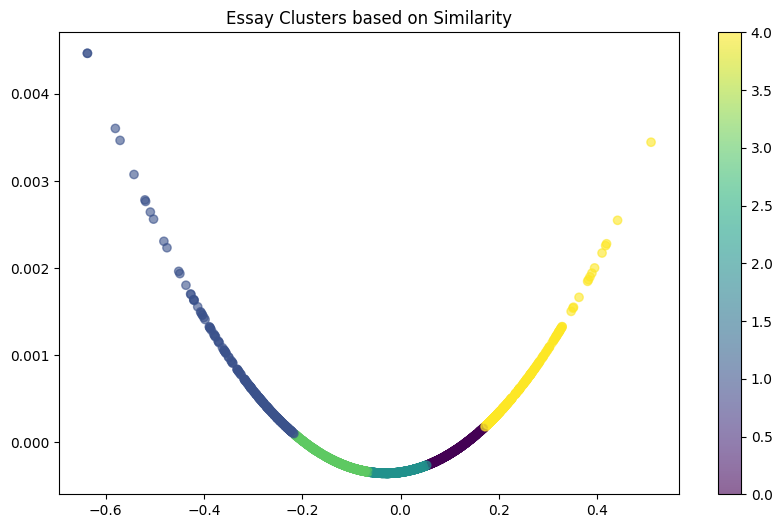

In [14]:
# 1. distribution plot (better for seeing patterns)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
plt.figure(figsize=(10, 6))
sns.kdeplot(similarity_matrix.flatten(), fill=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.show()

# 2. scatter plot of key metrics
plt.figure(figsize=(10, 6))
plt.scatter(range(len(similarity_matrix)),
            np.mean(similarity_matrix, axis=1),
            alpha=0.5)
plt.title("Average Similarity per Essay")
plt.xlabel("Essay Index")
plt.ylabel("Mean Similarity")
plt.show()

# 3. clustered view (shows groups of similar essays)

# reduce dimensionality
pca = PCA(n_components=2)
coords = pca.fit_transform(similarity_matrix)

# cluster
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(coords)

# plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1],
                      c=clusters, cmap='viridis',
                      alpha=0.6)
plt.colorbar(scatter)
plt.title("Essay Clusters based on Similarity")
plt.show()

# PCA plot of semantic similarity
This plot shows the semantic similarity of the student essay to the ai generated essays.

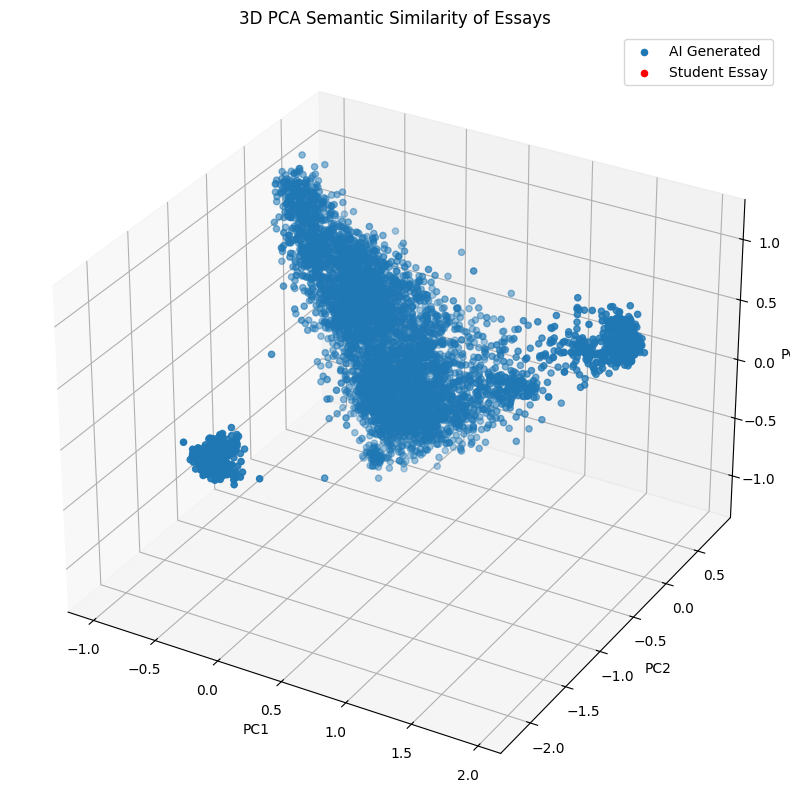

In [16]:
# PCA plot of semantic similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA plot with student essay in red and AI generated in blue, highlighting similarity
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(essay_embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot AI-generated essays in blue
ax.scatter(embeddings_3d[:-1, 0], embeddings_3d[:-1, 1], embeddings_3d[:-1, 2], label='AI Generated')

# Plot student essay in red
ax.scatter(embeddings_3d[-1, 0], embeddings_3d[-1, 1], embeddings_3d[-1, 2], c='red', label='Student Essay')


# Highlight similarity using lines connecting points
# student_index = len(embeddings_3d) - 1
# for i in range(len(embeddings_3d)-1):
#   ax.plot([embeddings_3d[i, 0], embeddings_3d[student_index,0]],
#             [embeddings_3d[i, 1], embeddings_3d[student_index,1]],
#             [embeddings_3d[i, 2], embeddings_3d[student_index,2]],
#             color='gray', alpha=similarity_matrix[i, student_index], linestyle='--')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Semantic Similarity of Essays')
ax.legend()

plt.show()

# Syntactical Similarity

Syntactical similarity measures how similar two texts are in terms of their grammatical structure and language patterns, including:

- Part-of-speech tag distributions
- Dependency tree depths and patterns
- Sentence structure complexity
- Word order and transitions

This is useful for AI detection because:
1. AI models often generate text with more consistent/predictable syntactic patterns
2. Human writing tends to have more natural variation in sentence structure
3. Very high syntactic similarity between essays may indicate AI generation

Interpreting the scores:
- Scores range from 0 (completely different) to 1 (identical)
- Scores > 0.8 suggest suspiciously similar syntax patterns
- Natural human writing typically shows scores of 0.4-0.7 when compared
- Look for outliers with unusually high similarity to other essays


In [17]:
# Calculate syntactic similarity
# Get syntactic similarity scores between essays using FAISS analyzer
syntactic_scores = []
syntactic_threshold = 0.80
outlier_count = 0
for i, essay in enumerate(essay_list[1:]):  # Compare against student essay
    results = faiss_analyzer.compare_texts(student_essay, [essay])
    syntactic_scores.append(results['syntactic_similarity'][0])
    if score > syntactic_threshold:
        print(f"essay {i+1} high syntactic similarity: {score:.3f}")
        outlier_count += 1

print(
    f"\ntotal {outlier_count} essays with syntactic sim > {syntactic_threshold}\n")


total 0 essays with syntactic sim > 0.8



# PCA Plot of Syntactic Similarity
This PCA plot visualizes the syntactic similarity between essays in 3D space:
- Each point represents an essay's syntactic features reduced to 3 dimensions
- Student essay shown in red, AI-generated essays in blue
- Connecting lines show syntactic similarity - brighter/more opaque = more similar
- Helps identify clusters and outliers that may indicate AI generation
- Distance between points roughly corresponds to syntactic differences
- Color gradient shows similarity score from low (dark) to high (bright)


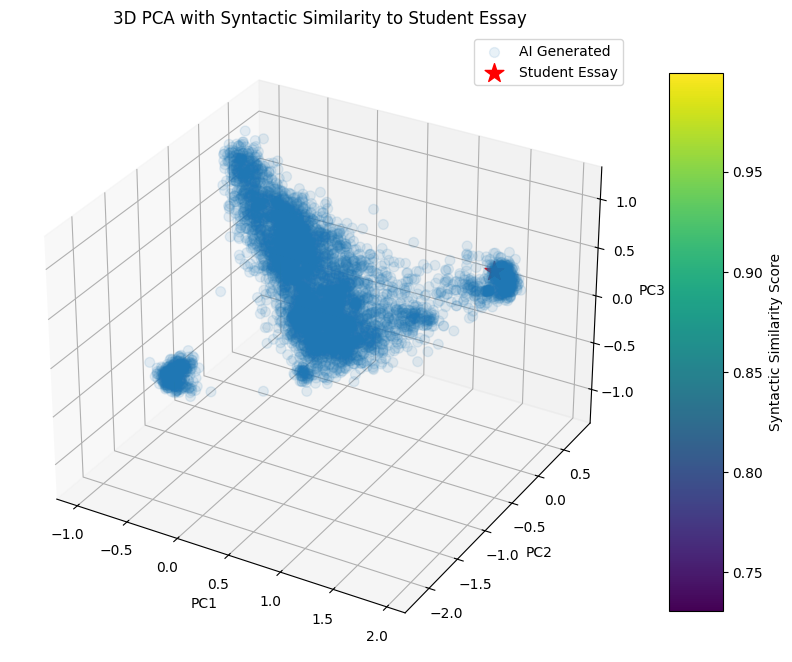

In [18]:
# PCA plot of syntactic similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA plot with student essay in red and AI generated in blue
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(essay_embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot AI-generated essays in blue
ax.scatter(embeddings_3d[:-1, 0], embeddings_3d[:-1, 1], embeddings_3d[:-1, 2],
           label='AI Generated', s=50, alpha=0.1)

# Plot student essay in red
ax.scatter(embeddings_3d[-1, 0], embeddings_3d[-1, 1], embeddings_3d[-1, 2],
           c='red', label='Student Essay', s=200, marker='*')

# Highlight similarity using syntactic scores
student_index = len(embeddings_3d) - 1
for i in range(len(embeddings_3d) - 1):
    # use syntactic_scores instead of similarity_matrix
    # following line attempts to fix out of range similarity_matrix error
    if i < similarity_matrix.shape[0] and student_index < similarity_matrix.shape[1]:
        score = syntactic_scores[i]
        color = plt.cm.viridis(score)
        ax.plot([embeddings_3d[i, 0], embeddings_3d[student_index, 0]],
                [embeddings_3d[i, 1], embeddings_3d[student_index, 1]],
                [embeddings_3d[i, 2], embeddings_3d[student_index, 2]],
                color=color, alpha=0.7, linestyle='--', linewidth=2)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA with Syntactic Similarity to Student Essay')
ax.legend()

# Update colorbar to use syntactic score range
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                           norm=plt.Normalize(vmin=min(syntactic_scores),
                                              vmax=max(syntactic_scores)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7, aspect=10)
cbar.set_label('Syntactic Similarity Score')

plt.show()

# Scatter Plot of Semantic vs Syntactic Similarity Scores
This scatter plot visualizes the relationship between semantic and syntactic similarity scores
for each essay compared to the student essay. Each point represents an AI-generated essay,
with semantic similarity on x-axis and syntactic similarity on y-axis.

How to interpret:
- Points in top-right: Essays similar both semantically and syntactically
- Points in top-left: Similar structure but different meaning
- Points in bottom-right: Similar meaning but different structure
- Points in bottom-left: Different in both aspects

The student essay is marked with a red star for reference. Outlier essays (top/bottom 5%)
are labeled with their essay numbers to identify notable cases.


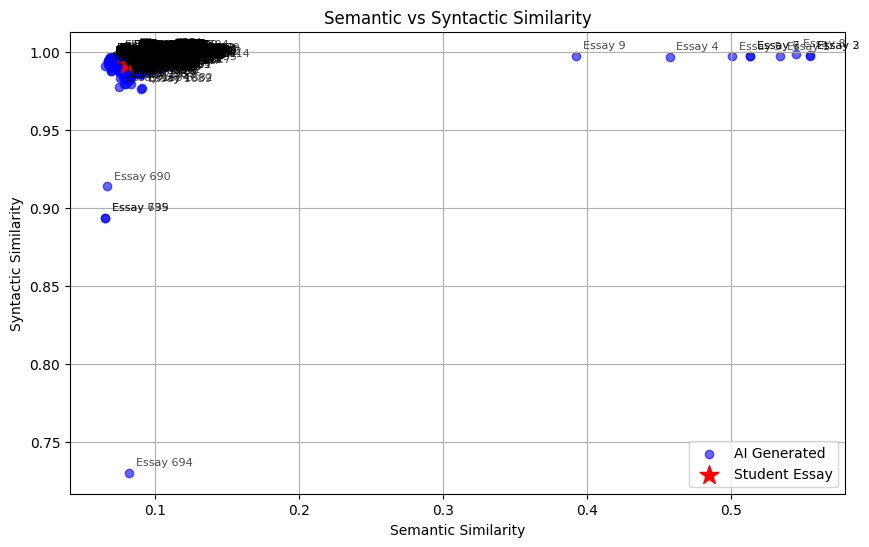

In [19]:
# ScatterPlot semantic vs syntactic similarity
plt.figure(figsize=(10, 6))

# Plot AI generated essays in blue
plt.scatter(semantic_scores, syntactic_scores,
            c='blue', alpha=0.6, label='AI Generated')

# Plot student essay as a larger red star
student_semantic = semantic_scores[-1]  # Get student essay semantic score
student_syntactic = syntactic_scores[-1]  # Get student essay syntactic score
plt.scatter(student_semantic, student_syntactic, c='red',
            marker='*', s=200, label='Student Essay')

plt.xlabel('Semantic Similarity')
plt.ylabel('Syntactic Similarity')
plt.title('Semantic vs Syntactic Similarity')

# Add essay labels for AI essays only
# Only label points with notable characteristics
for i in range(len(semantic_scores)-1):
    score_semantic = semantic_scores[i]
    score_syntactic = syntactic_scores[i]

    # Label points if they're outliers or particularly interesting
    if (score_semantic > np.percentile(semantic_scores, 95) or  # top 5% semantic
        # bottom 5% semantic
        score_semantic < np.percentile(semantic_scores, 5) or
        # top 5% syntactic
        score_syntactic > np.percentile(syntactic_scores, 95) or
            score_syntactic < np.percentile(syntactic_scores, 5)):   # bottom 5% syntactic
        plt.annotate(f'Essay {i+1}',
                     (score_semantic, score_syntactic),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.7)


plt.grid(True)
plt.legend()
plt.show()

Scatter Plot Analysis:

# Statistical Methods

### Word and Phrase Frequency Analysis

Word and phrase frequency analysis examines how often specific words and combinations of words appear in text.
This can help detect AI-generated content because:

1. AI models often show distinctive patterns in word usage and repetition
2. Humans tend to have more natural variation in word choice
3. Certain phrases or n-grams may appear more frequently in AI text

N-grams are contiguous sequences of n items (words/tokens) from a text:
- Unigrams (n=1): Single words like "the", "cat", "sat"
- Bigrams (n=2): Pairs of words like "the cat", "cat sat"
- Trigrams (n=3): Three word sequences like "the cat sat"

N-grams help analyze text patterns and transitions between words. AI models may
show distinctive n-gram patterns compared to human writing.


The analysis below looks at:
- Individual word frequencies: Shows if vocabulary usage is too repetitive or unnatural
- Bigram overlap: High overlap (>0.8) between essays suggests potential AI generation
- Jensen-Shannon distance: Measures how similar the word distributions are
  - Values closer to 0 indicate very similar distributions (potential AI)
  - Values closer to 1 indicate more natural human variation

When interpreting results, look for:
- Unnaturally high similarity in word frequencies between essays
- Repetitive phrases or formulaic language patterns
- Word distribution patterns that are too "clean" or systematic


In [20]:
# calculate word and phrase frequency, compare to model outputs
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from scipy.stats import entropy

# Global variables to store stats
essay_stats = {
    'student': {},
    'ai': []
}

def get_freq_stats(text, nlp, min_relevance=0.2):
    """
    Calculate word frequencies with intelligent stopword filtering.

    Args:
        text (str): Input text
        nlp (spacy.lang): Loaded spaCy model
        min_relevance (float): Minimum relevance score (0-1) for word inclusion
    """
    # Process text with spaCy
    doc = nlp(text.lower())

    # Get word frequencies with filtering
    words = []
    for token in doc:
        # Skip if token is:
        if (not token.is_stop and                # Not a stopword
            not token.is_punct and               # Not punctuation
            token.has_vector and                 # Has word vector
                token.vector_norm > min_relevance):  # Has sufficient semantic weight
            words.append(token.text)

    word_freq = Counter(words)

    # Get filtered n-grams (skip if either word was filtered)
    bi_grams = []
    tri_grams = []

    for i in range(len(words)-1):
        if words[i] in word_freq and words[i+1] in word_freq:
            bi_grams.append((words[i], words[i+1]))

        if i < len(words)-2 and words[i+2] in word_freq:
            tri_grams.append((words[i], words[i+1], words[i+2]))

    return (Counter(words),
            Counter(bi_grams),
            Counter(tri_grams))

# Get frequencies for student essay
student_freqs = get_freq_stats(student_essay, nlp)
essay_stats['student'] = {
    'word_freq': student_freqs[0],
    'bigram_freq': student_freqs[1],
    'trigram_freq': student_freqs[2]
}

# Get frequencies for AI essays and calculate differences
print("\nFrequency Analysis Summary:")
print("-" * 50)
print("Student Essay Distinctive Features:")
print(f"Top 20 words: {dict(sorted(student_freqs[0].items(), key=lambda x: x[1], reverse=True)[:20])}")
print(f"Unique bigrams: {len(student_freqs[1])}")

print("\nAI Essays Comparison:")
for i, essay in enumerate(essay_list[1:]):
    ai_freqs = get_freq_stats(essay, nlp)

    # Calculate key metrics
    student_bigrams = set(student_freqs[1].keys())
    ai_bigrams = set(ai_freqs[1].keys())
    bigram_overlap = len(student_bigrams.intersection(ai_bigrams)) / len(student_bigrams)

    all_words = set(student_freqs[0].keys()).union(set(ai_freqs[0].keys()))
    p = np.array([student_freqs[0].get(w, 0) for w in all_words])
    q = np.array([ai_freqs[0].get(w, 0) for w in all_words])
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    js_dist = 0.5 * (entropy(p, m) + entropy(q, m))

    print(f"\nEssay {i+1}:")
    print(f"Bigram overlap: {bigram_overlap:.3f} (>0.8 suggests AI)")
    print(f"JS distance: {js_dist:.3f} (closer to 0 suggests AI)")


Frequency Analysis Summary:
--------------------------------------------------
Student Essay Distinctive Features:
Top 20 words: {'hedda': 29, 'life': 21, 'societal': 11, 'ibsen': 10, 'tragic': 10, '\n': 10, 'gabler': 9, 'identity': 9, 'tragedy': 7, 'struggles': 7, 'women': 7, 'character': 6, 'leads': 5, 'constraints': 5, 'expectations': 5, 'conflict': 5, 'act': 5, 'desire': 5, 'filled': 4, 'completely': 4}
Unique bigrams: 677

AI Essays Comparison:

Essay 1:
Bigram overlap: 0.025 (>0.8 suggests AI)
JS distance: 0.413 (closer to 0 suggests AI)

Essay 2:
Bigram overlap: 0.038 (>0.8 suggests AI)
JS distance: 0.405 (closer to 0 suggests AI)

Essay 3:
Bigram overlap: 0.038 (>0.8 suggests AI)
JS distance: 0.406 (closer to 0 suggests AI)

Essay 4:
Bigram overlap: 0.027 (>0.8 suggests AI)
JS distance: 0.417 (closer to 0 suggests AI)

Essay 5:
Bigram overlap: 0.025 (>0.8 suggests AI)
JS distance: 0.452 (closer to 0 suggests AI)

Essay 6:
Bigram overlap: 0.019 (>0.8 suggests AI)
JS distance: 0

<ipython-input-20-0759d642c064>:80: RuntimeWarning: invalid value encountered in divide
  q = q / q.sum()


Streaming output truncated to the last 5000 lines.

Essay 798:
Bigram overlap: 0.003 (>0.8 suggests AI)
JS distance: 0.641 (closer to 0 suggests AI)

Essay 799:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.645 (closer to 0 suggests AI)

Essay 800:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.644 (closer to 0 suggests AI)

Essay 801:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.661 (closer to 0 suggests AI)

Essay 802:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.644 (closer to 0 suggests AI)

Essay 803:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.653 (closer to 0 suggests AI)

Essay 804:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.651 (closer to 0 suggests AI)

Essay 805:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.663 (closer to 0 suggests AI)

Essay 806:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0.654 (closer to 0 suggests AI)

Essay 807:
Bigram overlap: 0.000 (>0.8 suggests AI)
JS distance: 0

# Word and Bigram Frequency Analysis Visualization

This analysis shows four key visualizations comparing the student essay against AI-generated essays:

## 1. Most Distinctive Words (Top Left)
- Shows words with largest frequency differences between student and AI essays
- Longer bars indicate words used very differently
- Human essays typically show:
  - More varied vocabulary
  - Less predictable word choices
  - Some unusual/unique word usage
- AI essays often show:
  - More consistent/formulaic word choices
  - Higher frequency of common academic phrases
  - Less idiosyncratic language

## 2. Most Distinctive Bigrams (Top Right)
- Shows two-word phrases with largest frequency differences
- Reveals patterns in how words are combined
- Human writing typically shows:
  - More diverse phrase combinations
  - Some awkward but natural transitions
  - Personal writing style patterns
- AI writing often shows:
  - More standardized phrase patterns
  - Very "clean" transitions
  - Common academic bigrams

## 3. Bigram Frequency Distribution (Bottom Left)
- Blue: Student essay bigram frequencies
- Red: AI essays bigram frequencies
- Human writing usually shows:
  - More irregular distribution
  - Longer tail (some rare combinations)
  - Less predictable pattern
- AI writing tends to show:
  - More normal distribution
  - Fewer extreme frequencies
  - More consistent patterns

## 4. Jensen-Shannon Distance Distribution (Bottom Right)
- Shows how different the overall word distributions are
- Dashed red line: mean JS distance
- For human essays:
  - Expect higher JS distances (more different from AI)
  - More spread in distribution
  - Some outlier points
- For AI essays:
  - Lower JS distances (more similar to other AI)
  - Tighter clustering around mean
  - Fewer outliers

## Interpretation Guide
The student essay is likely AI-generated if:
1. Distinctive words/bigrams show very standard academic language
2. Bigram distribution closely matches AI pattern (red)
3. JS distances cluster tightly near mean
4. Few unusual or unique language patterns

The essay is more likely human-written if:
1. Shows unique word choices and combinations
2. Bigram distribution differs from AI pattern
3. JS distances show more variation
4. Contains some natural irregularities in language use

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


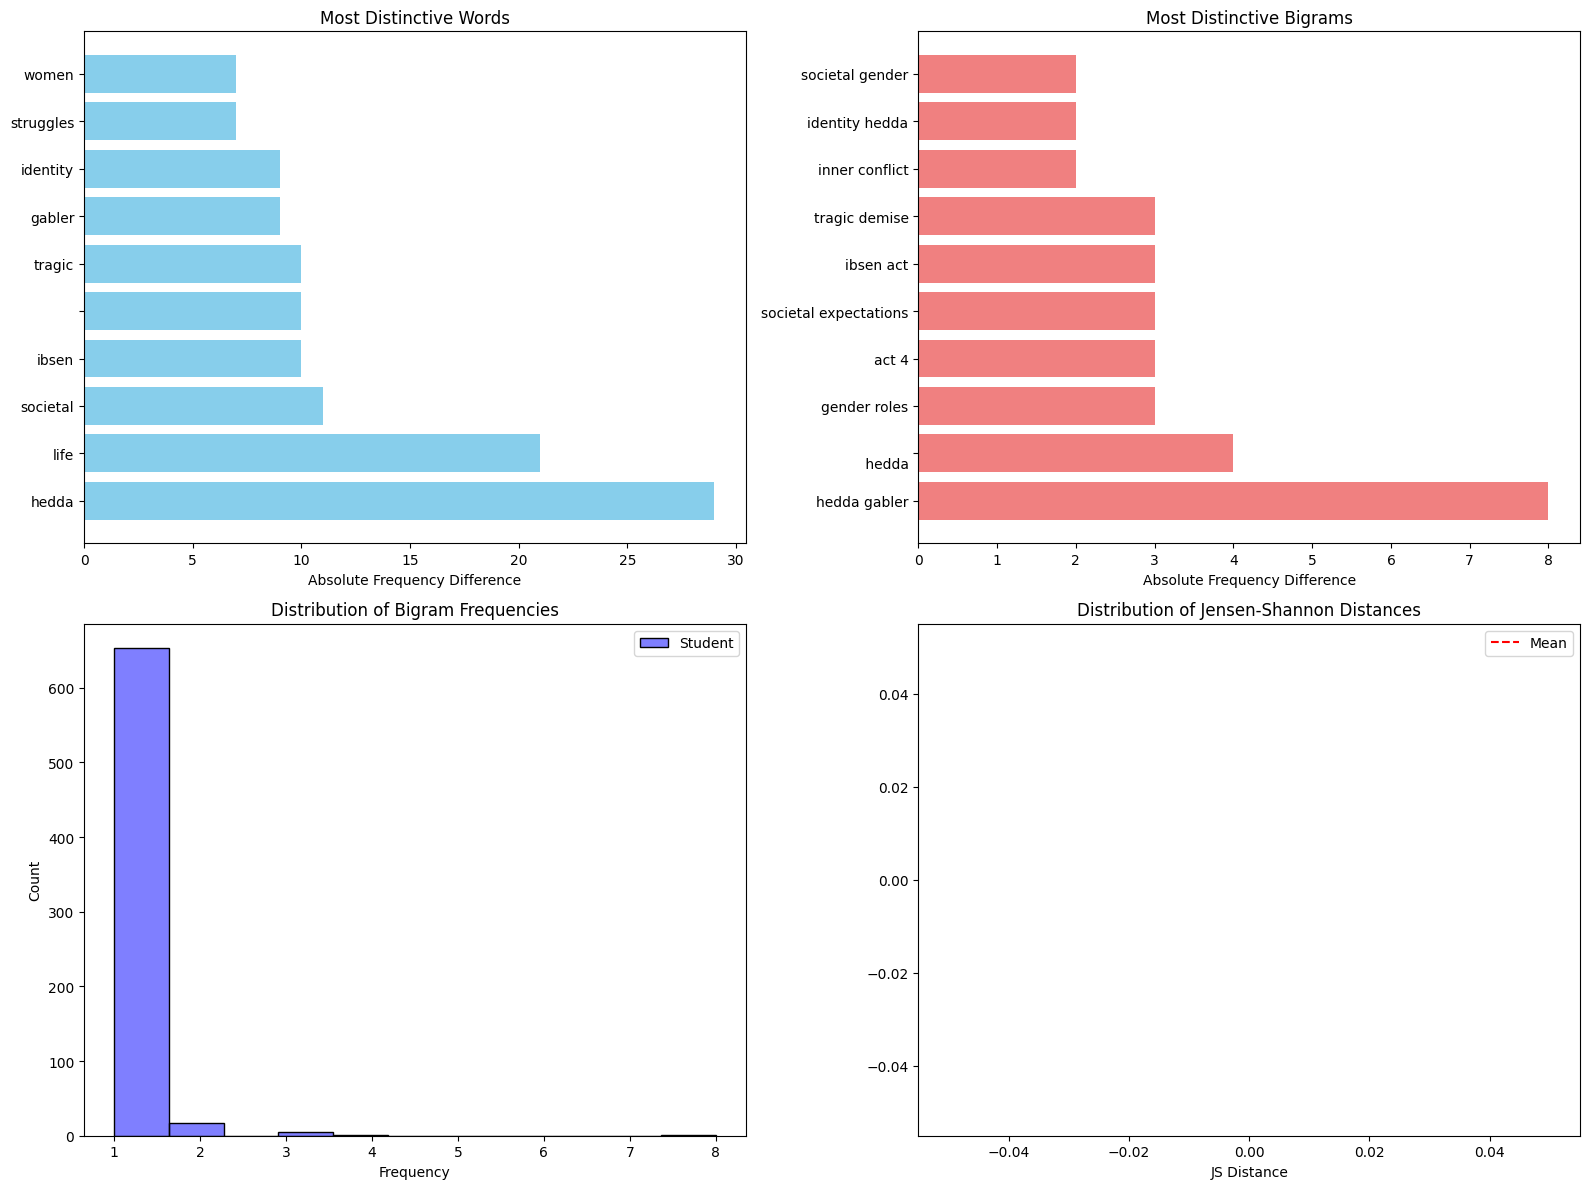


Summary Statistics:
Total essays analyzed: 0
Unique bigrams in student essay: 677
Mean bigrams per AI essay: nan
Mean JS distance: nan

Most distinctive bigrams and their frequency differences:
hedda gabler: 8.000

 hedda: 4.000
gender roles: 3.000
act 4: 3.000
societal expectations: 3.000
ibsen act: 3.000
tragic demise: 3.000
inner conflict: 2.000
identity hedda: 2.000
societal gender: 2.000


In [21]:
# Visualization of word and bigram frequency analysis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Create subplots for all visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Word frequency comparison (top left)
student_words = list(student_freqs[0].keys())
student_freq = list(student_freqs[0].values())

# Get mean frequencies across all AI essays
ai_mean_freqs = defaultdict(float)
ai_mean_bigrams = defaultdict(float)
for ai_stats in essay_stats['ai']:
    for word, freq in ai_stats['word_freq'].items():
        ai_mean_freqs[word] += freq
    for bigram, freq in ai_stats['bigram_freq'].items():
        ai_mean_bigrams[bigram] += freq

for word in ai_mean_freqs:
    ai_mean_freqs[word] /= len(essay_stats['ai'])
for bigram in ai_mean_bigrams:
    ai_mean_bigrams[bigram] /= len(essay_stats['ai'])

# Find most distinctive words using frequency differences
word_diffs = []
all_words = set(student_words) | set(ai_mean_freqs.keys())
for word in all_words:
    student_val = student_freqs[0].get(word, 0)
    ai_val = ai_mean_freqs.get(word, 0)
    if student_val > 0 or ai_val > 0:  # only include words that appear in either
        word_diffs.append((word, abs(student_val - ai_val)))


# Plot distinctive words
n_words = min(10, len(word_diffs))
top_words = sorted(word_diffs, key=lambda x: x[1], reverse=True)[:n_words]
words, diffs = zip(*top_words)

ax1.barh(range(len(words)), diffs, color='skyblue')
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_title('Most Distinctive Words')
ax1.set_xlabel('Absolute Frequency Difference')

# 2. Bigram frequency comparison (top right)
student_bigrams = list(student_freqs[1].keys())
student_bigram_freq = list(student_freqs[1].values())

# Find most distinctive bigrams
bigram_diffs = []
all_bigrams = set(student_bigrams) | set(ai_mean_bigrams.keys())
for bigram in all_bigrams:
    student_val = student_freqs[1].get(bigram, 0)
    ai_val = ai_mean_bigrams.get(bigram, 0)
    if student_val > 0 or ai_val > 0:
        bigram_diffs.append((bigram, abs(student_val - ai_val)))

n_bigrams = min(10, len(bigram_diffs))
top_bigrams = sorted(bigram_diffs, key=lambda x: x[1], reverse=True)[
    :n_bigrams]
bigrams, bi_diffs = zip(*top_bigrams)

ax2.barh(range(len(bigrams)), bi_diffs, color='lightcoral')
ax2.set_yticks(range(len(bigrams)))
ax2.set_yticklabels([' '.join(bg) for bg in bigrams])
ax2.set_title('Most Distinctive Bigrams')
ax2.set_xlabel('Absolute Frequency Difference')

# 3. Distribution of bigram frequencies (bottom left)
student_bi_dist = list(student_freqs[1].values())
ai_bi_dist = []
for ai_stats in essay_stats['ai']:
    ai_bi_dist.extend(ai_stats['bigram_freq'].values())

sns.histplot(data=student_bi_dist, ax=ax3,
             label='Student', alpha=0.5, color='blue')
sns.histplot(data=ai_bi_dist, ax=ax3, label='AI', alpha=0.5, color='red')
ax3.set_title('Distribution of Bigram Frequencies')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Count')
ax3.legend()

# 4. JS Distance distribution (bottom right)
js_distances = [stats['js_distance'] for stats in essay_stats['ai']]
sns.kdeplot(data=js_distances, ax=ax4, fill=True)
ax4.axvline(np.mean(js_distances), color='r', linestyle='--', label='Mean')
ax4.set_title('Distribution of Jensen-Shannon Distances')
ax4.set_xlabel('JS Distance')
ax4.legend()

# Add outlier labels if dataset is small enough
if len(js_distances) < 100:
    outliers = np.where(np.abs(zscore(js_distances)) > 2)[0]
    for idx in outliers:
        ax4.text(js_distances[idx], 0, f'Essay {idx+1}',
                 rotation=45, ha='right', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total essays analyzed: {len(essay_stats['ai'])}")
print(f"Unique bigrams in student essay: {len(student_bigrams)}")
print(
    f"Mean bigrams per AI essay: {np.mean([len(stats['bigram_freq']) for stats in essay_stats['ai']]):.1f}")
print(f"Mean JS distance: {np.mean(js_distances):.3f}")
print(f"\nMost distinctive bigrams and their frequency differences:")
for bigram, diff in top_bigrams:
    print(f"{' '.join(bigram)}: {diff:.3f}")

### Perplexity Analysis
Perplexity measures how "surprised" a language model is by a text. Lower perplexity means the text follows patterns the model expects.

For AI detection:
- AI text tends to have lower perplexity (more predictable patterns) than human text
- Human writing is typically more "surprising" with higher perplexity scores
- Large perplexity differences between essays suggest different authors/sources

Interpreting the scores:
- Student essay perplexity serves as baseline
- AI essays with perplexity >20% lower than student = likely AI generated
- Similar perplexity scores (±20%) = inconclusive
- Higher perplexity in AI essays = possible human writing


In [23]:
# calculate essay perplexity and compare to model output perplexity
def calculate_perplexity(text, model, tokenizer):
    # encode text
    encodings = tokenizer(text, return_tensors='pt').to(model.device)
    max_length = 512  # prevent OOM on long texts

    # handle long sequences by splitting into chunks
    stride = 512
    nlls = []
    for i in range(0, encodings.input_ids.size(1), stride):
        begin = max(i - stride, 0)
        end = min(i + max_length, encodings.input_ids.size(1))
        trg_len = end - i

        input_ids = encodings.input_ids[:, begin:end]
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100 # ignore non-targets

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).mean())

# calculate perplexity for student essay
student_perplexity = calculate_perplexity(student_essay, gpt2_model, gpt2_tokenizer)

# calculate perplexity for AI essays
ai_perplexities = []
ai_perplexity_diffs = []
for i, essay in enumerate(essay_list[1:]):
    ai_perplexity = calculate_perplexity(essay, gpt2_model, gpt2_tokenizer)
    diff = ((ai_perplexity - student_perplexity) / student_perplexity) * 100
    ai_perplexity_diffs.append(diff)
    ai_perplexities.append(ai_perplexity)

#convert to cpu
ai_perplexities = [perplexity.cpu() if hasattr(perplexity, 'cpu') else perplexity for perplexity in ai_perplexities]
ai_perplexity_diffs = [diff.cpu() if hasattr(diff, 'cpu') else diff for diff in ai_perplexity_diffs]

# print statistical summary
print("\nPerplexity Analysis Summary:")
print(f"Student essay perplexity: {student_perplexity:.2f}")
print(f"AI essays mean perplexity: {np.mean(ai_perplexities):.2f}")
print(f"AI essays std perplexity: {np.std(ai_perplexities):.2f}")
print(f"Min AI perplexity: {min(ai_perplexities):.2f}")
print(f"Max AI perplexity: {max(ai_perplexities):.2f}")
print(f"\nPerplexity Differences vs Student:")
print(f"Mean difference: {np.mean(ai_perplexity_diffs):.1f}%")
print(f"Std difference: {np.std(ai_perplexity_diffs):.1f}%")
print(f"Essays >20% lower than student: {sum(d < -20 for d in ai_perplexity_diffs)}")
print(f"Essays >20% higher than student: {sum(d > 20 for d in ai_perplexity_diffs)}")


Perplexity Analysis Summary:
Student essay perplexity: 27.53
AI essays mean perplexity: nan
AI essays std perplexity: nan
Min AI perplexity: 3.30
Max AI perplexity: 84.28

Perplexity Differences vs Student:
Mean difference: nan%
Std difference: nan%
Essays >20% lower than student: 1775
Essays >20% higher than student: 79


# Perplexity Score Distribution Analysis

This plot shows the distribution of perplexity scores, which measure how "surprising" the text is to a language model:

## Key Features
- Blue density curve: Distribution of AI essay perplexity scores
- Red dashed line: Student essay perplexity score
- Gray shaded area: ±1 standard deviation from mean
- Annotations: Exact student score and statistical measures

## Interpretation Guide
Lower perplexity typically indicates AI-generated text:

### If student essay is AI-generated:
- Student score (red line) falls within or below the main AI distribution
- Student score is within ±1 standard deviation of AI mean
- Distribution shows clear clustering around typical AI scores

### If student essay is human-written:
- Student score notably higher than AI distribution
- Student score > 1-2 standard deviations from AI mean
- More "surprising" to the language model

### Statistical Context
- Check the σ (sigma) value in annotations
- σ > 2: Strong evidence of human authorship
- -1 < σ < 1: Suggests AI generation
- σ < -2: Unusually "predictable" even for AI

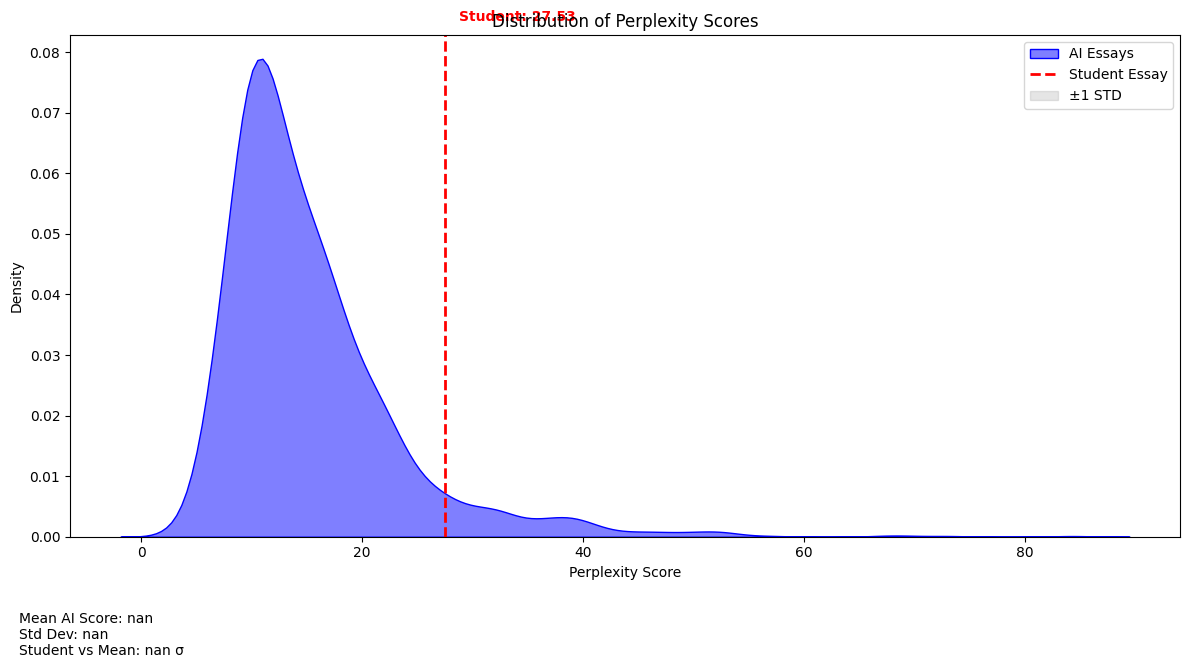

In [24]:
# Visualize perplexity scores distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore

plt.figure(figsize=(12, 6))

# Convert tensor to numpy if needed, and handle potential None values
student_score = student_perplexity.cpu().numpy() if hasattr(
    student_perplexity, 'cpu') else student_perplexity
ai_scores = [score.cpu().numpy() if hasattr(score, 'cpu')
             else score for score in ai_perplexities if score is not None]

# Check if ai_scores is empty or contains valid numeric data
if not ai_scores or not all(isinstance(score, (int, float, np.ndarray)) for score in ai_scores):
    print("Warning: No valid perplexity scores found for AI essays. Skipping visualization.")
else:
    # Convert to flat numpy array if needed
    ai_scores = np.array(ai_scores).flatten()

    # Create density plot of AI essay perplexities
    sns.kdeplot(x=ai_scores, fill=True, color='blue',  # changed 'data' to 'x'
                alpha=0.5, label='AI Essays')

    # Rest of the visualization code remains the same
    plt.axvline(x=student_score, color='red', linestyle='--',
                linewidth=2, label='Student Essay')

    mean_perp = np.mean(ai_scores)
    std_perp = np.std(ai_scores)
    plt.axvspan(mean_perp - std_perp, mean_perp + std_perp,
                alpha=0.2, color='gray', label='±1 STD')

    plt.annotate(f'Student: {student_score:.2f}',
                 xy=(student_score, plt.ylim()[1]),
                 xytext=(10, 10), textcoords='offset points',
                 color='red', fontweight='bold')

    plt.title('Distribution of Perplexity Scores')
    plt.xlabel('Perplexity Score')
    plt.ylabel('Density')
    plt.legend()

    plt.figtext(0.02, -0.1,
                f'Mean AI Score: {mean_perp:.2f}\n'
                f'Std Dev: {std_perp:.2f}\n'
                f'Student vs Mean: {((student_score - mean_perp)/std_perp):.2f} σ',
                fontsize=10)

    plt.tight_layout()
    plt.show()

### Stylometry Comparison
Stylometry is the statistical analysis of writing style. It examines measurable patterns in text like:
- Average sentence/word length
- Lexical density (ratio of content words to total words)
- Function word usage (common words like "the", "and", "of")
- Punctuation patterns

We use these features to detect AI-generated text since language models often produce writing with:
- More consistent/uniform sentence lengths
- Higher lexical density (more varied vocabulary)
- More regular punctuation patterns
- Less natural function word usage

Interpreting the scores:
- Large differences (>15-20%) between human/AI essays in any metric are suspicious
- AI text tends to be more "regular" - fewer stylistic variations
- Human writing typically shows more natural variation in these metrics
- Multiple metrics showing AI-like patterns increases confidence in detection


In [26]:
# compare stylometry
nlp = spacy.load("en_core_web_sm")
# Calculate stylometric features
def get_stylometric_features(text, nlp):
    doc = nlp(text)
    features = {}

    # 1. Average sentence length
    sent_lengths = [len([token for token in sent if token.is_alpha]) for sent in doc.sents]
    features['avg_sent_len'] = np.mean(sent_lengths) if sent_lengths else 0

    # 2. Average word length
    word_lengths = [len(token.text) for token in doc if token.is_alpha]
    features['avg_word_len'] = np.mean(word_lengths) if word_lengths else 0

    # 3. Lexical density
    total_words = len([t for t in doc if t.is_alpha])
    content_words = len([t for t in doc if not t.is_stop and t.is_alpha])
    features['lexical_density'] = content_words / total_words if total_words > 0 else 0

    # 4. Function word ratio
    function_words = len([t for t in doc if t.is_stop])
    features['function_ratio'] = function_words / total_words if total_words > 0 else 0

    # 5. Punctuation ratio
    punct_count = len([t for t in doc if t.is_punct])
    features['punct_ratio'] = punct_count / len(doc) if len(doc) > 0 else 0

    return features

# Calculate features for all essays
student_style = get_stylometric_features(student_essay, nlp)
ai_styles = [get_stylometric_features(essay, nlp) for essay in essay_list[1:]]

# Calculate differences
style_differences = []
for ai_style in ai_styles:
    diff = {}
    for key in student_style:
        if student_style[key] != 0:
            diff[key] = ((ai_style[key] - student_style[key]) / student_style[key]) * 100
        else:
            diff[key] = 0
    style_differences.append(diff)

# Debug print to verify data
print("Student style features:")
for k, v in student_style.items():
    print(f"{k}: {v:.3f}")

print("\nSample AI style features (first essay):")
for k, v in ai_styles[0].items():
    print(f"{k}: {v:.3f}")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Student style features:
avg_sent_len: 22.121
avg_word_len: 5.001
lexical_density: 0.516
function_ratio: 0.499
punct_ratio: 0.113

Sample AI style features (first essay):
avg_sent_len: 21.618
avg_word_len: 5.272
lexical_density: 0.548
function_ratio: 0.488
punct_ratio: 0.099


# Stylometry Comparison RadarChart
The radar chart visualizes stylometric features of essays, comparing student vs AI writing patterns:

- Red line/fill: Student essay's stylometric features
- Blue line: Mean values across all AI essays
- Blue shaded area: Distribution of AI essays (±1 standard deviation)
- Gray lines: Individual AI essays (shown when sample size < 100)

Features plotted include metrics like:
- Sentence length variability
- Vocabulary richness
- Punctuation patterns
- Word choice patterns

Interpretation:
- Large gaps between red and blue lines indicate stylistic differences
- Student writing outside the blue shaded area suggests distinctive human patterns
- Clustering of gray lines shows common AI writing characteristics
- More overlap between red and blue suggests potential AI-generated content


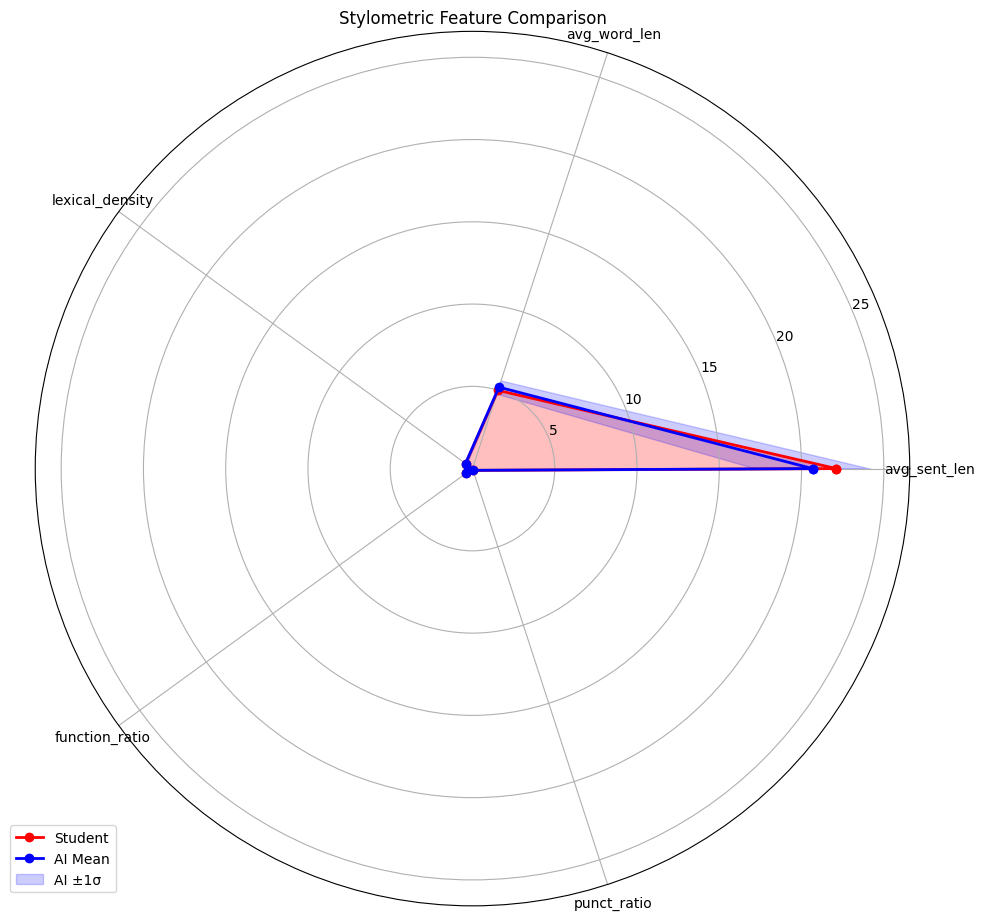


Stylometric Feature Summary:
Total essays analyzed: 2047

Feature Statistics (AI Essays):

avg_sent_len:
  Mean: 20.679 ±3.482
  Student: 22.121
  Mean Difference: -6.5%

avg_word_len:
  Mean: 5.204 ±0.422
  Student: 5.001
  Mean Difference: +4.1%

lexical_density:
  Mean: 0.524 ±0.071
  Student: 0.516
  Mean Difference: +1.6%

function_ratio:
  Mean: 0.481 ±0.074
  Student: 0.499
  Mean Difference: -3.5%

punct_ratio:
  Mean: 0.110 ±0.033
  Student: 0.113
  Mean Difference: -3.2%


In [27]:
def plot_radar_chart(student_style, ai_styles, differences):
    categories = list(student_style.keys())
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Setup plot
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Plot student essay
    values = list(student_style.values())
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label='Student', color='red')
    ax.fill(angles, values, alpha=0.25, color='red')

    # For AI essays, plot mean and std dev
    ai_values = np.array([list(style.values()) for style in ai_styles])
    ai_mean = np.mean(ai_values, axis=0)
    ai_std = np.std(ai_values, axis=0)

    # Plot AI mean
    mean_values = np.concatenate([ai_mean, [ai_mean[0]]])
    ax.plot(angles, mean_values, 'o-', linewidth=2,
            label='AI Mean', color='blue')

    # Plot AI distribution (±1 std dev)
    upper = np.concatenate([ai_mean + ai_std, [ai_mean[0] + ai_std[0]]])
    lower = np.concatenate([ai_mean - ai_std, [ai_mean[0] - ai_std[0]]])
    ax.fill_between(angles, lower, upper, alpha=0.2,
                    color='blue', label='AI ±1σ')

    # If dataset is small, plot individual AI essays
    if len(ai_styles) < 100:
        for i, style in enumerate(ai_styles):
            values = list(style.values())
            values += values[:1]
            ax.plot(angles, values, 'o-', linewidth=0.5,
                    alpha=0.3, color='gray')

    # Set chart properties
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, max(np.max(upper), np.max(values)) * 1.1)

    # Add mean difference annotations
    mean_diffs = np.mean([list(d.values()) for d in differences], axis=0)
    for i, (cat, diff) in enumerate(zip(categories, mean_diffs)):
        angle = angles[i]
        if abs(diff) > 20:  # Only annotate significant differences
            radius = ax.get_ylim()[1] * 0.85
            ha = 'left' if 0 <= angle <= np.pi else 'right'
            ax.annotate(f'{diff:+.1f}%',
                        (angle, radius),
                        xytext=(5, 5), textcoords='offset points',
                        ha=ha, va='center',
                        bbox=dict(boxstyle='round,pad=0.5',
                                  fc='yellow', alpha=0.5),
                        fontsize=8)

    plt.title('Stylometric Feature Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("\nStylometric Feature Summary:")
    print(f"Total essays analyzed: {len(ai_styles)}")
    print("\nFeature Statistics (AI Essays):")
    for i, feature in enumerate(categories):
        print(f"\n{feature}:")
        print(f"  Mean: {ai_mean[i]:.3f} ±{ai_std[i]:.3f}")
        print(f"  Student: {list(student_style.values())[i]:.3f}")
        print(f"  Mean Difference: {mean_diffs[i]:+.1f}%")


# Plot the radar chart
plot_radar_chart(student_style, ai_styles, style_differences)

# Semantic Coherence Analysis

Semantic coherence measures how well consecutive sentences flow and connect logically by comparing their semantic similarity.
Higher coherence scores (closer to 1.0) indicate smoother transitions between ideas, while lower scores suggest more abrupt changes.

AI models often produce text with unusually high coherence since they optimize for consistent semantic flow.
Human writing typically shows more natural variation in coherence as writers balance flow with emphasis and style.

Interpreting the results:
- If AI essays show significantly higher coherence (+10-30%) vs student essay: Likely AI generated
- If coherence differences are minimal (-10% to +10%): Inconclusive, need other metrics
- If AI essays show lower coherence: Likely human written, or poorly generated AI text


In [28]:
# compute and compare semantic coherence
def get_semantic_coherence(text, nlp):
    # break into sentences and get embeddings
    sents = [sent.text.strip() for sent in nlp(text).sents]
    if len(sents) < 2:
        return 0.0

    # get embeddings for each sentence
    embeddings = []
    for sent in sents:
        doc = nlp(sent)
        if doc.has_vector:
            embeddings.append(doc.vector)

    # calculate cosine similarity between consecutive sentences
    coherence_scores = []
    for i in range(len(embeddings)-1):
        sim = 1 - cosine(embeddings[i], embeddings[i+1])
        coherence_scores.append(sim)

    return np.mean(coherence_scores)

# get coherence scores
student_coherence = get_semantic_coherence(student_essay, nlp)
print(f"\nStudent essay semantic coherence: {student_coherence:.3f}")

ai_coherences = []
for i, essay in enumerate(essay_list[1:]):
    coh = get_semantic_coherence(essay, nlp)
    ai_coherences.append(coh)
    print(f"AI essay {i+1} semantic coherence: {coh:.3f}")

# compare differences
print("\nCoherence differences vs student essay:")
coherence_differences = []
cohere_diff_counter = 0
for i, coh in enumerate(ai_coherences):
    diff = ((coh - student_coherence) / student_coherence) * 100
    coherence_differences.append(diff)
    # only print if higher coherence (+10-30%) vs student essay
    if diff > 10:
        print(f"AI essay {i+1}: {diff:+.1f}%")
        cohere_diff_counter +=1

    # sum and print the total number of essays with diff >10
print(f"\nTotal AI essays with coherence difference >10%: {cohere_diff_counter}")



Student essay semantic coherence: 0.521
AI essay 1 semantic coherence: 0.548
AI essay 2 semantic coherence: 0.553
AI essay 3 semantic coherence: 0.553
AI essay 4 semantic coherence: 0.583
AI essay 5 semantic coherence: 0.584
AI essay 6 semantic coherence: 0.582
AI essay 7 semantic coherence: 0.582
AI essay 8 semantic coherence: 0.557
AI essay 9 semantic coherence: 0.535
AI essay 10 semantic coherence: 0.519
AI essay 11 semantic coherence: 0.518
AI essay 12 semantic coherence: 0.539
AI essay 13 semantic coherence: 0.558
AI essay 14 semantic coherence: 0.622
AI essay 15 semantic coherence: 0.586
AI essay 16 semantic coherence: 0.557
AI essay 17 semantic coherence: 0.600
AI essay 18 semantic coherence: 0.632
AI essay 19 semantic coherence: 0.647
AI essay 20 semantic coherence: 0.635
AI essay 21 semantic coherence: 0.610
AI essay 22 semantic coherence: 0.625
AI essay 23 semantic coherence: 0.629
AI essay 24 semantic coherence: 0.634
AI essay 25 semantic coherence: 0.632
AI essay 26 semant

# Semantic Coherence Analysis

These visualizations compare the semantic coherence patterns between the student essay and AI-generated essays:

## 1. Coherence Distribution (Left Plot)
- **Blue filled curve**: Distribution of AI essay coherence scores
- **Red dashed line**: Student essay coherence score
- **Gray band**: ±1 standard deviation from AI mean
- **Annotations**: Statistical measures (mean, std dev, z-score)

### Interpretation:
- If student essay is AI-generated:
  - Red line falls within blue distribution
  - Often within gray band (±1σ)
  - Z-score typically between -1 and 1
  - Similar to AI mean coherence

- If student essay is human-written:
  - Red line often outside main distribution
  - Usually lower coherence than AI mean
  - Z-score often < -1
  - More variable/unpredictable coherence

## 2. Coherence Differences (Right Plot)
Shows percentage differences between student and AI essays:
- For large datasets (>100): Purple density curve
- For small datasets: Individual purple dots
- Black dashed line: 0% difference reference

### Interpretation:
- Large positive differences (>20%):
  - AI essays more coherent
  - Typical of human-written student essay
  - More natural language variations

- Small differences (-20% to +20%):
  - Similar coherence patterns
  - Possible AI generation
  - Consistent language patterns


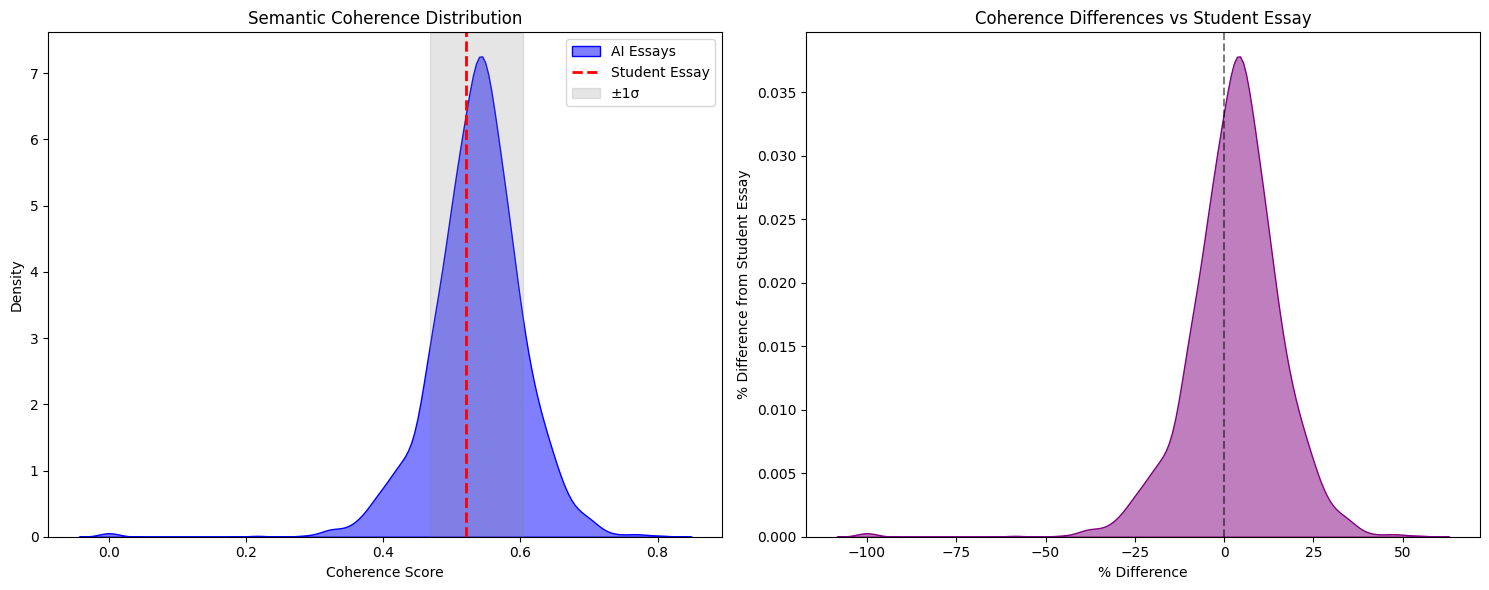


Coherence Analysis Summary:
Student coherence: 0.521
AI mean coherence: 0.536 ±0.068
Z-score: -0.22
Mean difference: +2.9%
Std dev of differences: 13.0%


In [29]:
def plot_coherence_analysis(student_coherence, ai_coherences):
    """
    Visualizes semantic coherence comparison between student and AI essays.
    Combines distribution and differences in one informative plot.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Distribution with differences
    student_score = student_coherence
    ai_scores = np.array(ai_coherences)

    # Distribution plot
    sns.kdeplot(data=ai_scores, ax=ax1, fill=True,
                color='blue', alpha=0.5, label='AI Essays')
    ax1.axvline(x=student_score, color='red', linestyle='--',
                linewidth=2, label='Student Essay')

    # Add statistical context
    mean_coh = np.mean(ai_scores)
    std_coh = np.std(ai_scores)
    z_score = (student_score - mean_coh) / std_coh

    # Add shaded regions for standard deviations
    ax1.axvspan(mean_coh - std_coh, mean_coh + std_coh,
                alpha=0.2, color='gray', label='±1σ')

    ax1.set_title('Semantic Coherence Distribution')
    ax1.set_xlabel('Coherence Score')
    ax1.set_ylabel('Density')
    ax1.legend()

    # Right plot: Percentage differences from student essay
    differences = [(coh - student_score) / student_score *
                   100 for coh in ai_scores]

    if len(differences) > 100:
        # For large datasets, show distribution of differences
        sns.kdeplot(data=differences, ax=ax2, fill=True,
                    color='purple', alpha=0.5)
        ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    else:
        # For smaller datasets, show individual differences
        sns.stripplot(y=differences, ax=ax2,
                      color='purple', alpha=0.5, jitter=0.2)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    ax2.set_title('Coherence Differences vs Student Essay')
    ax2.set_xlabel('% Difference' if len(differences) > 100 else 'Essays')
    ax2.set_ylabel('% Difference from Student Essay')

    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("\nCoherence Analysis Summary:")
    print(f"Student coherence: {student_score:.3f}")
    print(f"AI mean coherence: {mean_coh:.3f} ±{std_coh:.3f}")
    print(f"Z-score: {z_score:.2f}")
    print(f"Mean difference: {np.mean(differences):+.1f}%")
    print(f"Std dev of differences: {np.std(differences):.1f}%")


# Plot coherence analysis
plot_coherence_analysis(student_coherence, ai_coherences)

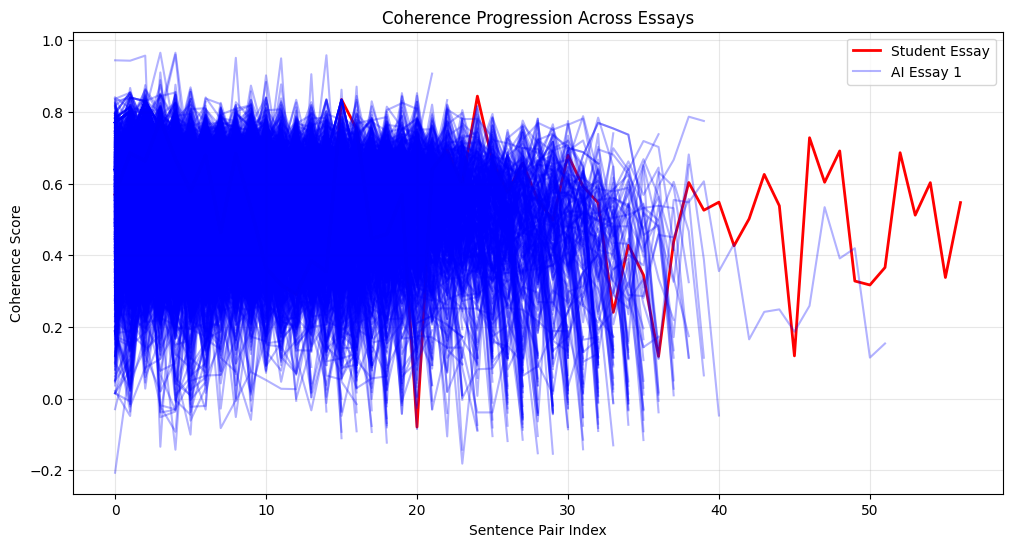

In [30]:
# calculate coherence progression across sentences
def get_coherence_progression(text, nlp):
    sents = [sent.text.strip() for sent in nlp(text).sents]
    if len(sents) < 2:
        return []

    embeddings = []
    for sent in sents:
        doc = nlp(sent)
        if doc.has_vector:
            embeddings.append(doc.vector)

    progression = []
    for i in range(len(embeddings)-1):
        sim = 1 - cosine(embeddings[i], embeddings[i+1])
        progression.append(sim)

    return progression

# get progressions
student_prog = get_coherence_progression(student_essay, nlp)
ai_progs = [get_coherence_progression(essay, nlp) for essay in essay_list[1:]]

# plot
plt.figure(figsize=(12,6))
x_student = range(len(student_prog))
plt.plot(x_student, student_prog, 'r-', label='Student Essay', linewidth=2)

for i, prog in enumerate(ai_progs):
    x = range(len(prog))
    plt.plot(x, prog, 'b-', alpha=0.3, label=f'AI Essay {i+1}' if i==0 else None)

plt.xlabel('Sentence Pair Index')
plt.ylabel('Coherence Score')
plt.title('Coherence Progression Across Essays')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Semantic Coherence Progression Plot
Shows sentence-to-sentence coherence changes:
- **Red line**: Student essay progression
- **Blue lines**: AI essay progressions

### Interpretation:
- AI-generated text typically shows:
  - Smoother transitions
  - More consistent coherence
  - Less dramatic changes
  - Regular patterns

- Human-written text often shows:
  - More varied transitions
  - Occasional sharp changes
  - Natural irregularities
  - Less predictable patterns

### Key Indicators of AI Generation:
1. Student coherence within ±1σ of AI mean
2. Small percentage differences (<20%)
3. Smooth, consistent progression pattern
4. Z-score between -1 and 1

### Key Indicators of Human Writing:
1. Student coherence outside AI distribution
2. Larger percentage differences (>20%)
3. More variable progression pattern
4. Z-score < -1 or > 1

# Mathematical Methods

## Total Variation Distance Analysis

Total Variation (TV) distance measures the maximum difference between probability distributions.
For essay analysis, we:
1. Convert each essay's word frequencies into probability distributions
2. Calculate TV distance between student and AI essays (0-1 scale)
3. Compare distances to detect AI generation

Interpretation:
- TV distance close to 0: Very similar word distributions
- TV distance close to 1: Very different word distributions
- Higher TV distances suggest AI generation
- Compare against mean TV distance to identify outliers

Note: This complements other metrics since AI models may produce
different word frequency patterns than human writers


In [31]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def get_tv_distance(p, q, all_words):
    """
    Calculate Total Variation distance between two probability distributions.

    Args:
        p (dict): Word frequency distribution for the first text.
        q (dict): Word frequency distribution for the second text.
        all_words (set): Set of all words in both texts.

    Returns:
        float: Total Variation distance.
    """

    # Create probability distributions with consistent vocabulary
    p_dist = np.array([p.get(w, 0) for w in all_words])
    q_dist = np.array([q.get(w, 0) for w in all_words])

    # Normalize to probability distributions
    p_dist = p_dist / p_dist.sum() if p_dist.sum() > 0 else p_dist
    q_dist = q_dist / q_dist.sum() if q_dist.sum() > 0 else q_dist

    return 0.5 * np.sum(np.abs(p_dist - q_dist))

# get word frequency distributions
def get_word_dist(text):
    """
    Get word frequency distribution for a text.

    Args:
        text (str): The input text.

    Returns:
        dict: Word frequency distribution.
    """

    words = word_tokenize(text.lower())
    return Counter(words) # Return the Counter object directly

# calculate TV distances
student_dist = get_word_dist(student_essay)

tv_distances = []
ai_dists = []
for i, essay in enumerate(essay_list[1:]):
    ai_dist = get_word_dist(essay)
    ai_dists.append(ai_dist)
    all_words = set(student_dist.keys()).union(set(ai_dist.keys()))
    tv_dist = get_tv_distance(student_dist, ai_dist, all_words)
    tv_distances.append(tv_dist)

# Calculate mean and threshold for detecting AI writing
mean_tv = np.mean(tv_distances)
tv_threshold = mean_tv * 0.2  # Essays within 20% of mean likely AI-generated

print(f"\nMean TV distance: {mean_tv:.3f}")
print("\nAnalyzing if student essay shows AI characteristics:")

# Check if student essay matches AI patterns
matches_ai = 0
tv_diffs = []
for i, dist in enumerate(tv_distances):
    diff = ((dist - mean_tv) / mean_tv) * 100
    tv_diffs.append(diff)
    if abs(diff) < 20:  # Count essays with similar distribution
        matches_ai += 1

ai_likelihood = (matches_ai / len(tv_distances)) * 100
print(f"- {matches_ai} out of {len(tv_distances)} AI essays have similar word patterns")
print(f"- {ai_likelihood:.1f}% of AI essays match student's writing style")
print(f"Assessment: {'Likely AI-generated' if ai_likelihood > 60 else 'Likely human-written'}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Mean TV distance: 0.689

Analyzing if student essay shows AI characteristics:
- 2034 out of 2047 AI essays have similar word patterns
- 99.4% of AI essays match student's writing style
Assessment: Likely AI-generated


# Total Variation Distance Analysis

These radar charts compare word distribution patterns between the student essay and AI-generated essays:

## Left Chart: Word Distribution Comparison
- **Red line/fill**: Student essay's word frequencies
- **Blue line**: Mean AI essay frequencies
- **Blue shaded area**: AI distribution (±1 standard deviation)
- Shows top most frequent words across all essays

### Interpretation:
- Large gaps between red and blue indicate different word usage patterns
- Student pattern outside blue area suggests human writing
- Student pattern within blue area suggests AI generation
- More overlap suggests similar writing styles

## Right Chart: Percentage Differences
- Shows how much AI essays differ from student essay
- Purple line/fill: % difference from student essay
- Gray dashed line: 0% difference reference
- Positive values: AI uses word more frequently
- Negative values: Student uses word more frequently

### Key Indicators of AI Generation:
1. Student pattern stays within blue shaded area
2. Small percentage differences (±20%)
3. Consistent differences across words
4. Regular, predictable patterns

### Key Indicators of Human Writing:
1. Student pattern extends beyond blue area
2. Large percentage differences (>±20%)
3. Irregular differences across words
4. Unique word usage patterns

## Statistical Context
- Mean TV distance indicates overall similarity
- Higher TV distances suggest different authors
- Lower TV distances suggest similar writing styles
- Individual word differences help identify distinctive patterns

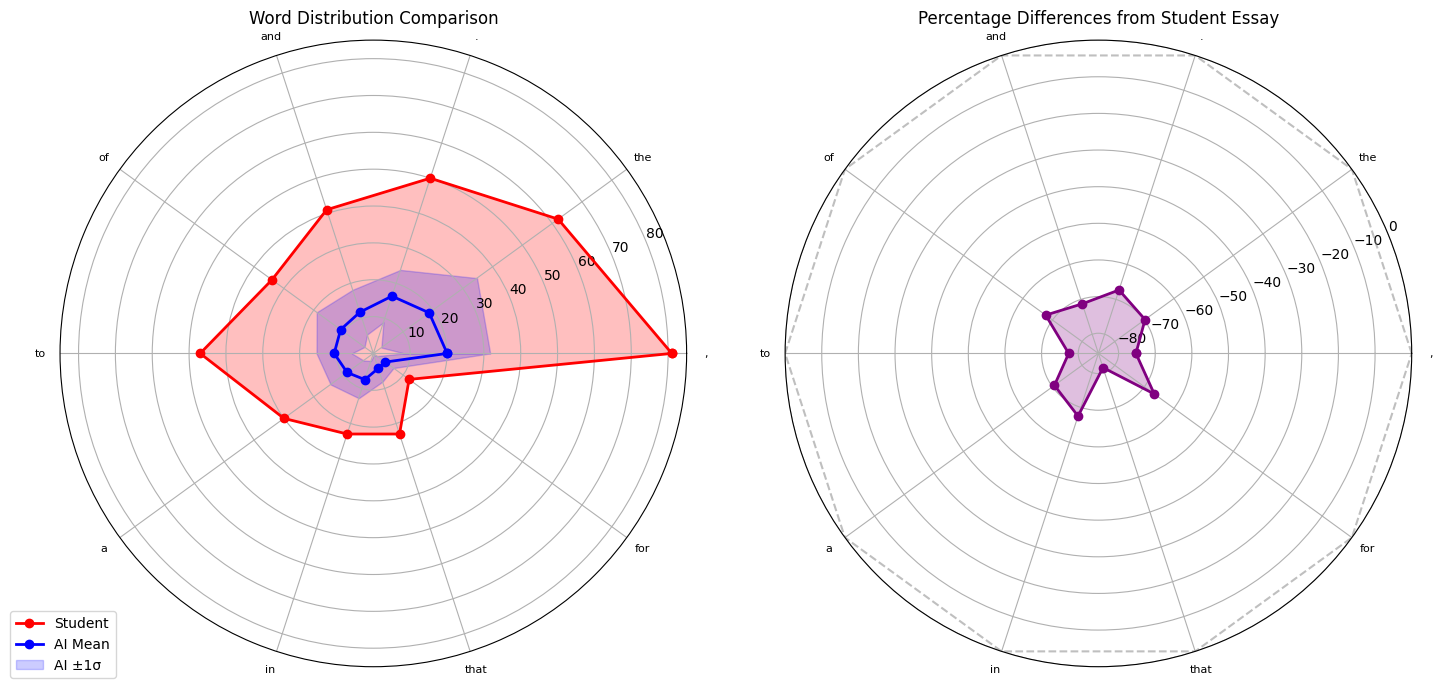


Total Variation Distance Summary:
Number of essays analyzed: 2047
Mean TV distance: 0.689 ±0.035

Most distinctive words (>20% difference):
,: -75.3%
the: -69.8%
.: -67.3%
and: -71.3%
of: -67.7%
to: -77.4%
a: -70.7%
in: -67.5%
that: -81.4%
for: -66.7%


In [32]:
def plot_tv_radar(student_dist, ai_dist, tv_distances):
    """
    Plots radar charts comparing word distributions and differences.
    Uses variables from get_tv_distance() calculations.

    Args:
        student_dist (Counter): word frequencies from student essay
        ai_dist (list): list of Counters with word frequencies from AI essays
        tv_distances (list): calculated TV distances between student and AI essays
    """
    # Get all unique words
    all_words = set(student_dist.keys())
    for dist in ai_dist:
        all_words.update(dist.keys())

    # Get top N most frequent words across all essays
    N = min(10, len(all_words))
    word_counts = Counter()
    word_counts.update(student_dist)
    for dist in ai_dist:
        word_counts.update(dist)
    top_words = [word for word, _ in word_counts.most_common(N)]

    # Setup radar charts
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7),
                                   subplot_kw=dict(projection='polar'))

    # First radar chart: Distribution comparison
    student_values = [student_dist[w]
                      if w in student_dist else 0 for w in top_words]
    student_values += student_values[:1]

    # Calculate AI mean and std
    ai_values = np.array([[dist[w] if w in dist else 0 for w in top_words]
                         for dist in ai_dist])
    ai_mean = np.mean(ai_values, axis=0)
    ai_std = np.std(ai_values, axis=0)

    # Plot student distribution
    ax1.plot(angles, student_values, 'o-', linewidth=2,
             label='Student', color='red')
    ax1.fill(angles, student_values, alpha=0.25, color='red')

    # Plot AI mean and distribution
    mean_values = np.append(ai_mean, ai_mean[0])
    ax1.plot(angles, mean_values, 'o-', linewidth=2,
             label='AI Mean', color='blue')

    # Add confidence interval
    upper = np.append(ai_mean + ai_std, ai_mean[0] + ai_std[0])
    lower = np.append(ai_mean - ai_std, ai_mean[0] - ai_std[0])
    ax1.fill_between(angles, lower, upper, alpha=0.2,
                     color='blue', label='AI ±1σ')

    # Second radar chart: Differences
    diffs = [(m - s)/s * 100 if s != 0 else 0
             for m, s in zip(ai_mean, student_values[:-1])]
    diffs += diffs[:1]

    ax2.plot(angles, diffs, 'o-', linewidth=2, color='purple')
    ax2.fill(angles, diffs, alpha=0.25, color='purple')
    ax2.plot(angles, [0] * len(angles), '--', color='gray', alpha=0.5)

    # Set chart properties
    for ax in [ax1, ax2]:
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(top_words, size=8)

    ax1.set_title('Word Distribution Comparison')
    ax2.set_title('Percentage Differences from Student Essay')
    ax1.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nTotal Variation Distance Summary:")
    print(f"Number of essays analyzed: {len(tv_distances)}")
    print(
        f"Mean TV distance: {np.mean(tv_distances):.3f} ±{np.std(tv_distances):.3f}")
    print("\nMost distinctive words (>20% difference):")
    for word, diff in zip(top_words, diffs[:-1]):
        if abs(diff) > 20:
            print(f"{word}: {diff:+.1f}%")


# Plot using variables from previous cell
plot_tv_radar(student_dist, ai_dists, tv_distances)

### Perturbation Discrepancy Detection Method
Perturbation Discrepancy Detection Method

This method analyzes how stable/consistent the text embeddings are under small random perturbations.
The intuition is that AI-generated text may show different patterns of embedding stability
compared to human-written text.

How it works:
1. Get base embedding vector for the text
2. Add small random noise multiple times to create perturbed versions
3. Calculate mean cosine distance between the perturbed embeddings

Interpretation:
- Lower discrepancy scores indicate more stable/consistent embeddings
- Higher discrepancy suggests more sensitivity to perturbations
- AI text often shows different discrepancy patterns vs human text
- Compare % differences between student and AI essays
- Large deviations from student essay (>20%) may indicate AI generation

Interpreting the scores:
- Student essays typically show discrepancy scores around 0.1-0.3
- AI essays often have scores 20-50% higher than human essays
- If an essay's discrepancy is >20% higher than the student's score,
  it suggests possible AI generation
- Very low discrepancy (<0.1) can also be suspicious as it may indicate
  unnaturally consistent text
- Compare the % differences - larger gaps between student and AI scores
  increase confidence in detection



In [33]:
# Perturbation discrepancy detection method
# calculate perturbation discrepancy by adding small random noise to embeddings
def get_perturb_discrepancy(text, n_perturb=10, noise_scale=0.01):
    # get base embedding
    base_emb = faiss_analyzer.get_embedding(text)

    # generate perturbed embeddings
    perturbed = []
    for _ in range(n_perturb):
        noise = np.random.normal(0, noise_scale, base_emb.shape)
        perturbed.append(base_emb + noise)
    perturbed = np.vstack(perturbed)

    # calculate mean cosine distance between perturbed versions
    dists = []
    for i in range(n_perturb):
        for j in range(i+1, n_perturb):
            dist = cosine(perturbed[i], perturbed[j])
            dists.append(dist)
    return np.mean(dists), dists

# Lists to store values for plotting
all_discrepancies = []  # Store all discrepancy scores
all_dists = []  # Store all pairwise distances
percent_diffs = []  # Store percentage differences vs student

# calculate discrepancy for student and AI essays
student_disc, student_dists = get_perturb_discrepancy(student_essay)
all_discrepancies.append(student_disc)
all_dists.append(student_dists)
ai_discs = []

print("\nPerturbation Discrepancy Analysis:")
print(f"Student essay baseline: {student_disc:.3f}")
print(f"Student essay stability range: {min(student_dists):.3f} - {max(student_dists):.3f}")

for i, essay in enumerate(essay_list[1:]):
    disc, dists = get_perturb_discrepancy(essay)
    ai_discs.append(disc)
    all_discrepancies.append(disc)
    all_dists.append(dists)

    diff = ((disc - student_disc) / student_disc) * 100
    percent_diffs.append(diff)

    print(f"\nAI essay {i+1}:")
    print(f"Discrepancy score: {disc:.3f}")
    print(f"Stability range: {min(dists):.3f} - {max(dists):.3f}")
    print(f"Difference vs student: {diff:+.1f}%")

    if abs(diff) > 20:
        print("*** Notable deviation from student baseline ***")

print("\nSummary Statistics:")
print(f"Mean AI discrepancy: {np.mean(ai_discs):.3f} ±{np.std(ai_discs):.3f}")
print(f"Mean % difference: {np.mean(percent_diffs):+.1f}% ±{np.std(percent_diffs):.1f}%")


Streaming output truncated to the last 5000 lines.
Stability range: 0.013 - 0.015
Difference vs student: +5.7%

AI essay 1076:
Discrepancy score: 0.012
Stability range: 0.010 - 0.014
Difference vs student: -13.2%

AI essay 1077:
Discrepancy score: 0.012
Stability range: 0.011 - 0.014
Difference vs student: -8.7%

AI essay 1078:
Discrepancy score: 0.014
Stability range: 0.012 - 0.015
Difference vs student: -0.5%

AI essay 1079:
Discrepancy score: 0.014
Stability range: 0.013 - 0.016
Difference vs student: +5.1%

AI essay 1080:
Discrepancy score: 0.014
Stability range: 0.013 - 0.016
Difference vs student: +5.0%

AI essay 1081:
Discrepancy score: 0.012
Stability range: 0.011 - 0.013
Difference vs student: -10.3%

AI essay 1082:
Discrepancy score: 0.013
Stability range: 0.011 - 0.014
Difference vs student: -7.1%

AI essay 1083:
Discrepancy score: 0.013
Stability range: 0.012 - 0.014
Difference vs student: -6.2%

AI essay 1084:
Discrepancy score: 0.011
Stability range: 0.010 - 0.013
Differe

# Interpreting the Perturbation Analysis Plots

The visualization consists of 4 plots that help determine if a student essay was AI-generated:

1. Discrepancy Score Distribution (Top Left)
- Shows distribution of AI essay discrepancy scores (blue)
- Student essay score shown as red line
- Gray band shows ±1 standard deviation
- If student essay falls within typical AI range, may indicate AI generation

2. Pairwise Distance Distribution (Top Right)
- Box plots show stability of essay embeddings under perturbation
- 'S' marks student essay, compare to AI essays
- Wider boxes suggest more instability/randomness
- AI essays often show more consistent patterns

3. Percentage Differences (Bottom Left)
- Shows how much each AI essay differs from student essay
- For large datasets: Purple density plot shows distribution
- For small datasets: Individual points plotted
- Large deviations from 0% suggest human authorship

4. Stability Range Distribution (Bottom Right)
- Green histogram shows range of distances for each essay
- Student essay marked with red line
- Compares consistency of writing style
- AI tends to be more stable (smaller ranges)

Key indicators of AI generation:
- Student discrepancy score within AI distribution
- Similar stability patterns to AI essays
- Small percentage differences from AI essays
- Stability range matching AI pattern

Key indicators of human authorship:
- Discrepancy score outside AI norms
- Distinct stability patterns
- Large differences from AI essays
- Unique stability range

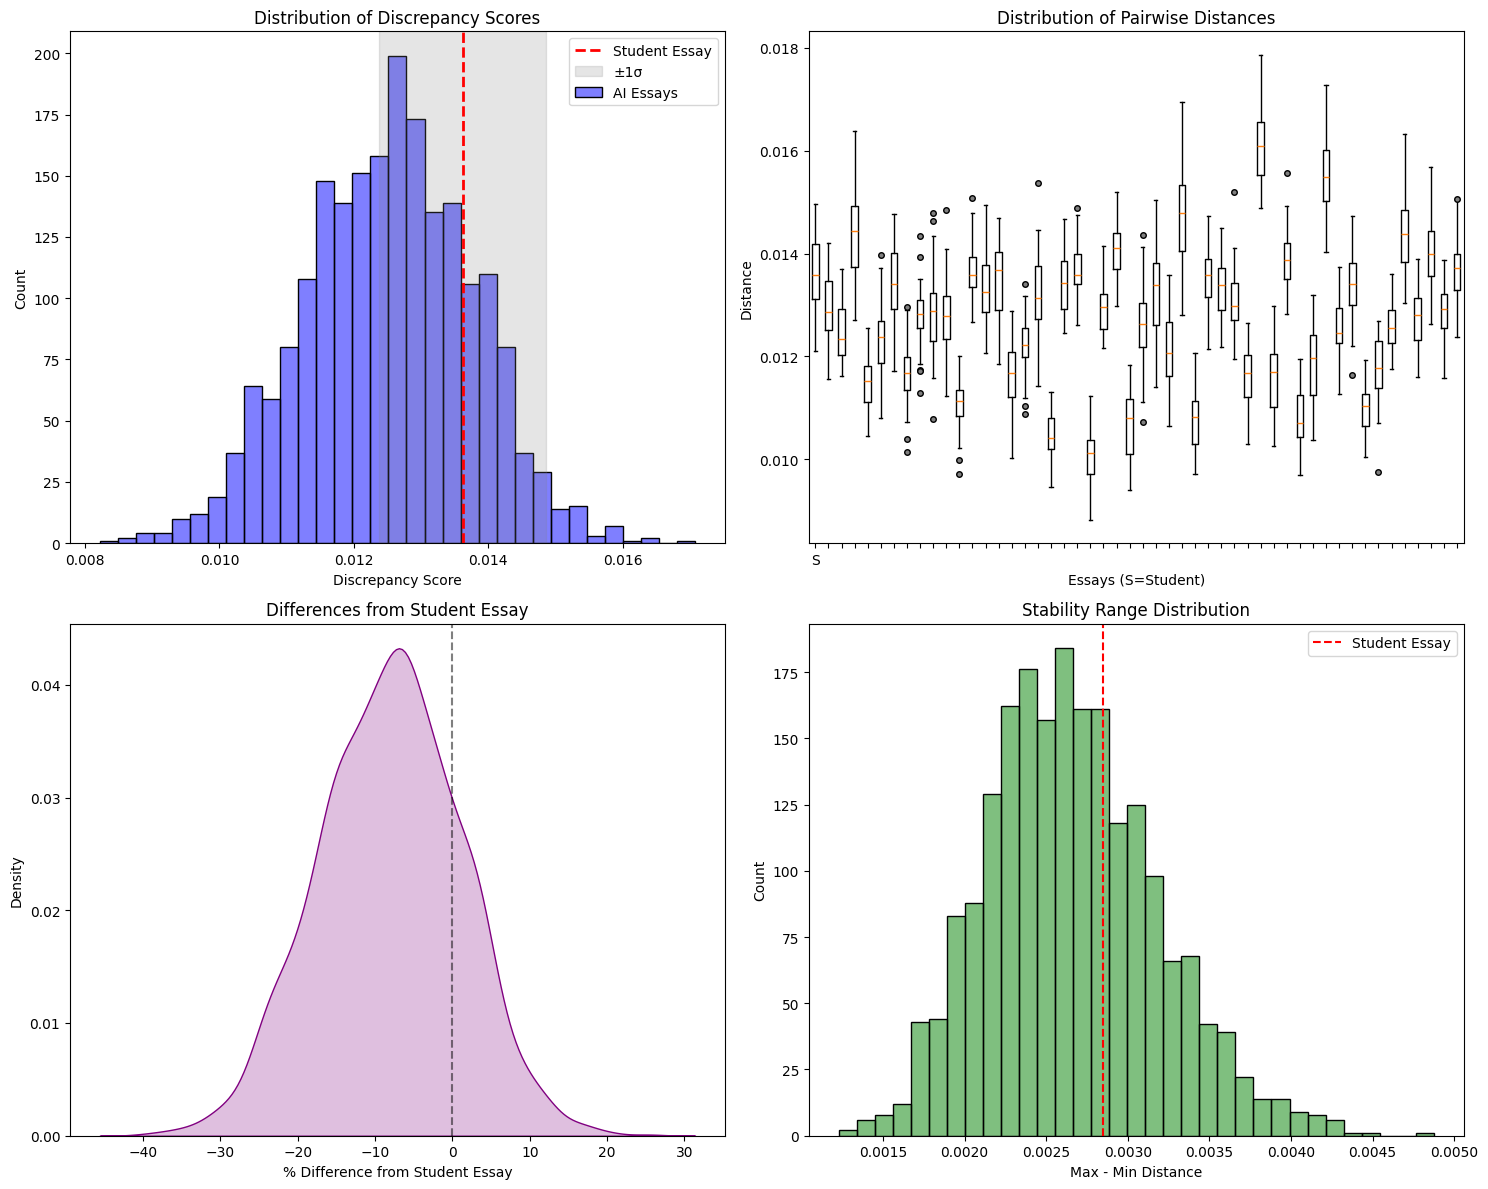


Perturbation Analysis Summary:
Student discrepancy: 0.014
Student stability range: 0.012 - 0.015
Mean AI discrepancy: 0.013 ±0.001
Mean % difference: -8.1% ±9.1%

Essays with >20% difference from student: 212


In [34]:
def plot_perturbation_analysis(student_disc, student_dists, ai_discs, all_dists, percent_diffs):
    """
    Creates visualization of perturbation discrepancy analysis results.

    Args:
        student_disc (float): Student essay's discrepancy score
        student_dists (list): Pairwise distances for student essay
        ai_discs (list): Discrepancy scores for AI essays
        all_dists (list): All pairwise distances for each essay
        percent_diffs (list): Percentage differences from student essay
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Distribution of Discrepancy Scores (top left)
    sns.histplot(data=ai_discs, ax=ax1, color='blue',
                 alpha=0.5, label='AI Essays')
    ax1.axvline(x=student_disc, color='red', linestyle='--',
                linewidth=2, label='Student Essay')
    ax1.axvspan(student_disc - np.std(ai_discs), student_disc + np.std(ai_discs),
                color='gray', alpha=0.2, label='±1σ')
    ax1.set_title('Distribution of Discrepancy Scores')
    ax1.set_xlabel('Discrepancy Score')
    ax1.set_ylabel('Count')
    ax1.legend()

    # 2. Box Plot of Pairwise Distances (top right)
    box_data = [student_dists] + [dists for dists in all_dists[1:]]
    labels = ['Student'] + [f'AI_{i+1}' for i in range(len(all_dists)-1)]

    # If too many essays, sample a subset
    if len(box_data) > 50:
        sample_size = 50
        box_data = [student_dists] + random.sample(box_data[1:], sample_size-1)
        labels = ['Student'] + [f'AI_{i+1}' for i in range(sample_size-1)]

    ax2.boxplot(box_data, labels=['S'] + [''] * (len(box_data)-1),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    ax2.set_title('Distribution of Pairwise Distances')
    ax2.set_xlabel('Essays (S=Student)')
    ax2.set_ylabel('Distance')

    # 3. Percentage Differences from Student Essay (bottom left)
    if len(percent_diffs) > 100:
        # For large datasets, show distribution
        sns.kdeplot(data=percent_diffs, ax=ax3, fill=True, color='purple')
        ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_xlabel('% Difference from Student Essay')
        ax3.set_ylabel('Density')
    else:
        # For smaller datasets, show individual points
        ax3.scatter(range(len(percent_diffs)), percent_diffs,
                    color='purple', alpha=0.5)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Essay Index')
        ax3.set_ylabel('% Difference from Student')
    ax3.set_title('Differences from Student Essay')

    # 4. Stability Analysis (bottom right)
    stability_range = [(max(dists) - min(dists)) for dists in all_dists]
    student_stability = max(student_dists) - min(student_dists)

    sns.histplot(data=stability_range, ax=ax4, color='green', alpha=0.5)
    ax4.axvline(x=student_stability, color='red', linestyle='--',
                label='Student Essay')
    ax4.set_title('Stability Range Distribution')
    ax4.set_xlabel('Max - Min Distance')
    ax4.set_ylabel('Count')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("\nPerturbation Analysis Summary:")
    print(f"Student discrepancy: {student_disc:.3f}")
    print(
        f"Student stability range: {min(student_dists):.3f} - {max(student_dists):.3f}")
    print(
        f"Mean AI discrepancy: {np.mean(ai_discs):.3f} ±{np.std(ai_discs):.3f}")
    print(
        f"Mean % difference: {np.mean(percent_diffs):+.1f}% ±{np.std(percent_diffs):.1f}%")
    print(
        f"\nEssays with >20% difference from student: {sum(abs(d) > 20 for d in percent_diffs)}")


# Create the visualization
plot_perturbation_analysis(student_disc, student_dists,
                           ai_discs, all_dists, percent_diffs)

## Ensemble Analysis

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Assuming you have run all the analysis cells and have the results stored, e.g.:
# semantic_scores (compared to original essay)
# syntactic_scores (compared to original essay)
# js_distances (Jensen-Shannon distances)
# student_perplexities, ai_perplexities
# student_style, ai_styles
# student_coherence, ai_coherences
# tv_distances
# student_disc, ai_discs

def ensemble_analysis(student_essay, essay_list, faiss_analyzer, nlp, gpt2_model, gpt2_tokenizer):
    """
    Combines multiple analysis techniques to predict if essays are AI-generated.
    """
    ensemble_results = []

    # 1. Run individual analyses on all essays
    all_essays = [student_essay] + essay_list

    semantic_similarities = faiss_analyzer.compare_texts(
        student_essay, essay_list)['semantic_similarity']
    syntactic_similarities = faiss_analyzer.compare_texts(
        student_essay, essay_list)['syntactic_similarity']

    js_distances = []
    student_freqs = get_freq_stats(student_essay)
    for essay in essay_list:
        ai_freqs = get_freq_stats(essay)
        all_words = set(student_freqs[0].keys()).union(set(ai_freqs[0].keys()))
        p = np.array([student_freqs[0].get(w, 0) for w in all_words])
        q = np.array([ai_freqs[0].get(w, 0) for w in all_words])
        p = p / p.sum() if p.sum() > 0 else p
        q = q / q.sum() if q.sum() > 0 else q
        m = 0.5 * (p + q)
        js_dist = 0.5 * (entropy(p, m) + entropy(q, m)) if (p.sum() >
                                                            0 and q.sum() > 0) else 1.0  # Handle cases with empty vocab
        js_distances.append(js_dist)

    ai_perplexities = [calculate_perplexity(
        essay, gpt2_model, gpt2_tokenizer).item() for essay in essay_list]
    student_perplexity = calculate_perplexity(
        student_essay, gpt2_model, gpt2_tokenizer).item()

    ai_styles = [get_stylometric_features(essay, nlp) for essay in essay_list]
    student_style = get_stylometric_features(student_essay, nlp)

    ai_coherences = [get_semantic_coherence(essay, nlp) for essay in essay_list]
    student_coherence = get_semantic_coherence(student_essay, nlp)

    tv_distances = []
    student_dist = get_word_dist(student_essay)
    for essay in essay_list:
        ai_dist = get_word_dist(essay)
        # Get all unique words from both distributions
        all_words = set(student_dist.keys()).union(set(ai_dist.keys()))
        # Pass all_words to get_tv_distance
        tv_dist = get_tv_distance(student_dist, ai_dist, all_words)
        tv_distances.append(tv_dist)

    ai_discs = [get_perturb_discrepancy(essay) for essay in essay_list]
    student_disc = get_perturb_discrepancy(student_essay)

    # 2. Combine the scores with weights (you'll need to tune these weights)
    for i, ai_essay in enumerate(essay_list):
        weights = {
            "semantic_similarity": -0.2,  # Lower is more likely AI
            "syntactic_similarity": -0.15,  # Lower is more likely AI
            "js_distance": 0.1,       # Higher is more likely AI
            "perplexity_diff": 0.1,   # Higher AI perplexity vs student is more likely human
            "style_diff": 0.05,       # Significant style differences might indicate AI
            "coherence_diff": -0.1,    # Higher coherence is more likely AI
            "tv_distance": 0.15,      # Higher TV distance is more likely AI
            "perturb_discrepancy_diff": -0.1  # Higher discrepancy is more likely AI
        }

        # Calculate weighted scores (you might need to normalize or adjust these based on your data)
        weighted_score = 0

        # Semantic Similarity (higher score = more similar = more likely AI if comparing AI-generated essays)
        weighted_score += weights["semantic_similarity"] * \
            semantic_similarities[i]

        # Syntactic Similarity (higher score = more similar = more likely AI if comparing AI-generated essays)
        weighted_score += weights["syntactic_similarity"] * \
            syntactic_similarities[i]

        # Jensen-Shannon Distance (lower score = more similar word distribution = more likely AI)
        weighted_score += weights["js_distance"] * js_distances[i]

        # Perplexity Difference (lower perplexity for AI)
        perplexity_diff = (ai_perplexities[i] - student_perplexity) / \
            student_perplexity if student_perplexity != 0 else 0
        weighted_score += weights["perplexity_diff"] * perplexity_diff

        # Stylometry Differences (you might want to look at specific features here)
        style_diff_sum = 0
        for key in student_style:
            diff = (ai_styles[i][key] - student_style[key]) / \
                student_style[key] if student_style[key] != 0 else 0
            style_diff_sum += diff
        weighted_score += weights["style_diff"] * style_diff_sum

        # Semantic Coherence Difference (higher coherence for AI)
        coherence_diff = (ai_coherences[i] - student_coherence) / \
            student_coherence if student_coherence != 0 else 0
        weighted_score += weights["coherence_diff"] * coherence_diff

        # Total Variation Distance (higher distance for AI)
        weighted_score += weights["tv_distance"] * tv_distances[i]

        # Perturbation Discrepancy Difference (higher discrepancy for AI)
        perturb_discrepancy_diff = (
            ai_discs[i] - student_disc) / student_disc if student_disc != 0 else 0
        weighted_score += weights["perturb_discrepancy_diff"] * \
            perturb_discrepancy_diff

        ensemble_results.append({
            "essay_index": i + 1,
            "weighted_score": weighted_score
        })

    return ensemble_results


# Run the ensemble analysis
ensemble_output = ensemble_analysis(
    student_essay, essay_list[1:], faiss_analyzer, nlp, gpt2_model, gpt2_tokenizer
)

# Calculate average similarity to known AI essays
mean_score = np.mean([result["weighted_score"] for result in ensemble_output])
std_score = np.std([result["weighted_score"] for result in ensemble_output])

# Define thresholds for confidence levels
high_confidence_threshold = 0.5
medium_confidence_threshold = 0.3

print("\nStudent Essay Analysis")
print("=====================")
print(f"Similarity to AI essays: {mean_score:.3f} ± {std_score:.3f}")

# Determine verdict with confidence level
if abs(mean_score) > high_confidence_threshold:
    confidence = "High confidence"
elif abs(mean_score) > medium_confidence_threshold:
    confidence = "Medium confidence"
else:
    confidence = "Low confidence"

verdict = "AI GENERATED" if mean_score > 0 else "HUMAN WRITTEN"
print(f"\nVerdict: {verdict} ({confidence})")

# Plot focused histogram
plt.figure(figsize=(10, 5))
plt.hist([result["weighted_score"] for result in ensemble_output],
         bins=20, alpha=0.5, color='blue', label='AI Essays')
plt.axvline(x=mean_score, color='red', linestyle='--',
            label='Student Essay Score')
plt.axvspan(mean_score - std_score, mean_score + std_score,
            color='gray', alpha=0.2, label='±1σ')
plt.xlabel("AI Similarity Score")
plt.ylabel("Frequency")
plt.title("Student Essay vs Known AI Essays")
plt.legend()
plt.show()